In [ ]:
# pip install -r requirements.txt

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 66.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlin

## Attention Mechanisms: `SelfAttention` and `CrossAttention`

Attention mechanisms are a cornerstone of modern deep learning architectures, particularly Transformers, and play a crucial role in Stable Diffusion's UNet model. They allow the model to weigh the importance of different parts of input sequences when producing an output. This section details two types of attention used: **Self-Attention**, where a sequence attends to itself, and **Cross-Attention**, where one sequence attends to another.

---

### 🧠 `SelfAttention`

The `SelfAttention` module allows tokens within a single input sequence to interact with each other. This means that for each token, the module can determine which other tokens in the same sequence are most relevant and incorporate their information into its representation. This is vital for understanding context and relationships within the sequence itself, for example, how different parts of an image relate to one another.

**Initialization (`__init__`)**

* `n_heads` (int): The number of attention heads. Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions.
* `d_embed` (int): The dimensionality of the input embedding (and also the output embedding).
* `in_proj` (`nn.Linear`): A single linear layer that projects the input embedding `x` into Query (Q), Key (K), and Value (V) matrices simultaneously. This is an optimization where `d_embed` is mapped to `3 * d_embed`, and then this output is chunked.
* `out_proj` (`nn.Linear`): A linear layer that projects the concatenated outputs of the attention heads back to the original embedding dimension `d_embed`.
* `d_head` (int): The dimensionality of each attention head, calculated as `d_embed // n_heads`.

**Forward Pass (`forward`)**

1.  **Input Preparation**:
    * `x`: The input tensor of shape `(Batch_Size, Seq_Len, Dim)`, where `Dim` is `d_embed`.
    * `causal_mask` (bool): If `True`, applies a causal mask to ensure that a position can only attend to previous positions (and itself). This is typically used in autoregressive models like decoders in Transformers but might be relevant in specific UNet layers if sequential order matters (e.g., for time embeddings, though not typically for spatial self-attention in UNets).

2.  **Projection to Q, K, V**:
    * The input `x` is passed through `self.in_proj` to get a tensor of shape `(Batch_Size, Seq_Len, 3 * Dim)`.
    * This tensor is then `chunk(3, dim=-1)` to separate it into Q, K, and V, each of shape `(Batch_Size, Seq_Len, Dim)`.

3.  **Multi-Head Reshaping**:
    * Q, K, and V are reshaped and transposed to `(Batch_Size, n_heads, Seq_Len, d_head)` to prepare for parallel attention computation across heads.

4.  **Scaled Dot-Product Attention**:
    * **Compute Attention Scores**: The dot product of Q and the transpose of K (`K.transpose(-1, -2)`) is computed: $QK^T$. This results in raw attention scores (weights) of shape `(Batch_Size, n_heads, Seq_Len, Seq_Len)`.
    * **Causal Masking (Optional)**: If `causal_mask` is `True`, the upper triangle of the attention scores matrix is filled with negative infinity. This ensures that after the softmax operation, positions cannot attend to future positions.
    * **Scaling**: The scores are scaled by dividing by the square root of `d_head` ($1/\sqrt{d_{head}}$). This helps stabilize gradients.
    * **Softmax**: A softmax function is applied along the last dimension (`dim=-1`) of the scaled scores to obtain the final attention weights. These weights sum to 1 and indicate the importance of each token relative to others.
    * **Compute Output**: The attention weights are multiplied by V (`weight @ V`) to get the weighted sum of values, resulting in an output of shape `(Batch_Size, n_heads, Seq_Len, d_head)`.

5.  **Output Processing**:
    * The output tensor is transposed back and reshaped to `(Batch_Size, Seq_Len, Dim)`.
    * This reshaped tensor is then passed through the `self.out_proj` linear layer to produce the final output of the self-attention module, with the same shape as the input `x`.

**Role in Stable Diffusion (UNet)**:
Within the UNet, self-attention layers help the model capture global context and long-range dependencies between different spatial locations in the feature maps at various resolutions. For example, it can help the model understand that a "blue sky" should consistently appear across the top of an image.

---

### 🔗 `CrossAttention`

The `CrossAttention` module allows one sequence (the query sequence, `x`) to attend to another sequence (the key/value context sequence, `y`). This is how information from a conditioning signal (like text embeddings) is injected into the image generation process. The query sequence (e.g., image latents) can selectively draw information from the context sequence.

**Initialization (`__init__`)**

* `n_heads` (int): Number of attention heads.
* `d_embed` (int): Dimensionality of the query input `x` and the output.
* `d_cross` (int): Dimensionality of the context input `y` from which Keys and Values are derived.
* `q_proj` (`nn.Linear`): Projects the query input `x` (from `d_embed` to `d_embed`).
* `k_proj` (`nn.Linear`): Projects the context input `y` (from `d_cross` to `d_embed`) to generate Keys.
* `v_proj` (`nn.Linear`): Projects the context input `y` (from `d_cross` to `d_embed`) to generate Values.
* `out_proj` (`nn.Linear`): Projects the concatenated head outputs back to `d_embed`.
* `d_head` (int): Dimensionality per head (`d_embed // n_heads`).

**Forward Pass (`forward`)**

1.  **Input Preparation**:
    * `x`: The query tensor, typically the image latents, with shape `(Batch_Size, Seq_Len_Q, Dim_Q)`, where `Dim_Q` is `d_embed`.
    * `y`: The context tensor, typically text embeddings, with shape `(Batch_Size, Seq_Len_KV, Dim_KV)`, where `Dim_KV` is `d_cross`.

2.  **Projection to Q, K, V**:
    * Query `q` is derived from `x` via `self.q_proj(x)`.
    * Key `k` is derived from `y` via `self.k_proj(y)`.
    * Value `v` is derived from `y` via `self.v_proj(y)`.
    All `q`, `k`, `v` will have an embedding dimension of `d_embed` (or `Dim_Q`).

3.  **Multi-Head Reshaping**:
    * `q`, `k`, and `v` are reshaped and transposed to accommodate multiple attention heads. For `q`: `(Batch_Size, n_heads, Seq_Len_Q, d_head)`. For `k` and `v`: `(Batch_Size, n_heads, Seq_Len_KV, d_head)`. Note that `Seq_Len_Q` (sequence length of `x`) and `Seq_Len_KV` (sequence length of `y`) can be different.

4.  **Scaled Dot-Product Attention**:
    * The process is similar to self-attention: $Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$.
    * The attention scores will have shape `(Batch_Size, n_heads, Seq_Len_Q, Seq_Len_KV)`.
    * The output after multiplying with `v` will have shape `(Batch_Size, n_heads, Seq_Len_Q, d_head)`.
    * Causal masking is not typically used in cross-attention for Stable Diffusion, as the image latents should be able to attend to all parts of the text prompt.

5.  **Output Processing**:
    * The output is transposed, made contiguous in memory (`.contiguous()`), and reshaped back to `(Batch_Size, Seq_Len_Q, d_embed)`.
    * This is then passed through `self.out_proj` to produce the final output.

**Role in Stable Diffusion (UNet)**:
Cross-attention is fundamental for conditioning the image generation on text prompts. At various stages in the UNet, the (noisy) image latents (`x`) attend to the text prompt embeddings (`y`). This allows the UNet to incorporate the semantic information from the prompt into the denoising process, guiding the image generation to match the textual description. For example, if the prompt is "a red apple," cross-attention helps ensure the generated object is indeed an apple and is colored red.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import math

class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # x: # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        # (Batch_Size, Seq_Len, H, Dim / H)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head)
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)
        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)
        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf)

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head)
        weight = F.softmax(weight, dim=-1)
        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v
        output = output.transpose(1, 2)
        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape)
        output = self.out_proj(output)
        return output

class CrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, y):
        # x (latent): # (Batch_Size, Seq_Len_Q, Dim_Q)
        # y (context): # (Batch_Size, Seq_Len_KV, Dim_KV) = (Batch_Size, 77, 768)
        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        # Divide each embedding of Q into multiple heads such that d_heads * n_heads = Dim_Q
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        q = self.q_proj(x)
        k = self.k_proj(y)
        v = self.v_proj(y)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) @ (Batch_Size, H, Dim_Q / H, Seq_Len_KV) -> (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = q @ k.transpose(-1, -2)
        weight /= math.sqrt(self.d_head)
        weight = F.softmax(weight, dim=-1)
        output = weight @ v
        output = output.transpose(1, 2).contiguous()
        # (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = output.view(input_shape)
        output = self.out_proj(output)

        return output

## 🖼️ VAE (Variational Autoencoder) Components

The Variational Autoencoder (VAE) in Stable Diffusion is responsible for compressing images from pixel space into a lower-dimensional latent space (Encoder) and decompressing them from the latent space back into pixel space (Decoder). The diffusion process itself operates on these latent representations. This section details the building blocks of the VAE Decoder.

---

### 👁️ `VAE_AttentionBlock`

This block incorporates a self-attention mechanism within the VAE's architecture, typically in both the encoder and decoder. It allows the model to capture global, long-range dependencies between different spatial locations in the feature maps.

**Initialization (`__init__`)**

* `channels` (int): The number of input and output channels for this block.
* `self.groupnorm` (`nn.GroupNorm`): A group normalization layer. Normalizes the features before the attention operation. `num_groups` is fixed at 32.
* `self.attention` (`SelfAttention`): An instance of the `SelfAttention` module (detailed previously). Here, it's configured with a single attention head (`n_heads=1`) and the dimensionality `channels`.

**Forward Pass (`forward`)**

1.  **Input**: `x` with shape `(Batch_Size, Features, Height, Width)`.
2.  **Residual Connection**: The input `x` is stored as `residue` for a skip connection.
3.  **Normalization**: `x` is passed through `self.groupnorm`.
4.  **Reshape for Attention**:
    * The spatial dimensions `Height` and `Width` are flattened into a single sequence length dimension: `(Batch_Size, Features, Height * Width)`.
    * The tensor is then transposed to `(Batch_Size, Height * Width, Features)`. This treats each "pixel's feature vector" as an element in a sequence, and `Features` as its embedding dimension.
5.  **Self-Attention**: The reshaped `x` is processed by `self.attention(x)`. Since `causal_mask` is not passed (or defaults to `False` in the `SelfAttention` module), all tokens can attend to all other tokens.
6.  **Reshape Back**:
    * The output from attention is transposed back to `(Batch_Size, Features, Height * Width)`.
    * It's then reshaped to its original spatial dimensions: `(Batch_Size, Features, Height, Width)`.
7.  **Add Residual**: The output of the attention mechanism (after reshaping) is added to the original `residue`.
8.  **Output**: The resulting tensor, with the same shape as the input.

**Role**: Helps the VAE learn relationships between distant parts of the image, improving the quality and coherence of the reconstructed (decoded) or encoded features.

---

### 🧱 `VAE_ResidualBlock`

This is a standard residual block, a common component in deep convolutional networks. It helps in training deeper models by mitigating the vanishing gradient problem and allowing for easier learning of identity mappings.

**Initialization (`__init__`)**

* `in_channels` (int): Number of channels in the input feature map.
* `out_channels` (int): Number of channels in the output feature map.
* `self.groupnorm_1`, `self.groupnorm_2` (`nn.GroupNorm`): Group normalization layers with 32 groups.
* `self.conv_1` (`nn.Conv2d`): The first 2D convolution with `kernel_size=3` and `padding=1` (preserves spatial dimensions). Maps `in_channels` to `out_channels`.
* `self.conv_2` (`nn.Conv2d`): The second 2D convolution, mapping `out_channels` to `out_channels`.
* `self.residual_layer` (`nn.Identity` or `nn.Conv2d`):
    * If `in_channels == out_channels`, this is an `nn.Identity()` layer, meaning the residue is passed through unchanged.
    * If `in_channels != out_channels`, this is a `nn.Conv2d` layer with `kernel_size=1` (a 1x1 convolution) used to project the residue from `in_channels` to `out_channels`, making the addition possible.

**Forward Pass (`forward`)**

1.  **Input**: `x` with shape `(Batch_Size, In_Channels, Height, Width)`.
2.  **Store Residue**: The input `x` is stored as `residue`.
3.  **First Convolutional Path**:
    * `x` is passed through `self.groupnorm_1`.
    * The result is activated by `F.silu` (Sigmoid Linear Unit).
    * The activated map is passed through `self.conv_1`.
4.  **Second Convolutional Path**:
    * The output from `conv_1` is passed through `self.groupnorm_2`.
    * The result is activated by `F.silu`.
    * The activated map is passed through `self.conv_2`.
5.  **Add Residual**: The output of `self.conv_2` is added to the (potentially projected by `self.residual_layer`) `residue`.
6.  **Output**: The resulting tensor, with shape `(Batch_Size, Out_Channels, Height, Width)`.

**Role**: These blocks are stacked to form the main convolutional pathways in both the VAE encoder and decoder, allowing for the extraction and refinement of hierarchical features.

---

### ✨ `VAE_Decoder`

The `VAE_Decoder` is an `nn.Sequential` model that reconstructs an image from its latent representation. It takes a compressed latent tensor (typically 4 channels for Stable Diffusion v1) and upsamples it through a series of convolutional, residual, and attention blocks to produce an image in pixel space (typically 3 channels for RGB).

**Architecture Overview**

The decoder is built as a sequence of layers:

1.  **Initial Convolutions**: Starts with a 1x1 convolution followed by a 3x3 convolution to expand the initial 4 latent channels to 512 feature channels.
2.  **Blocks of Processing**: Consists of several `VAE_ResidualBlock`s and `VAE_AttentionBlock`s. These process the features at a given spatial resolution.
3.  **Upsampling**: `nn.Upsample(scale_factor=2)` layers are interspersed to double the height and width of the feature maps. After each upsample, a 3x3 convolution is usually applied, followed by more residual/attention blocks. This upsampling happens three times, effectively increasing the spatial dimensions by a factor of $2^3 = 8$.
4.  **Channel Reduction**: As spatial resolution increases, the number of channels is gradually reduced (e.g., from 512 to 256, then to 128).
5.  **Final Output Layers**: After the last set of blocks, a `nn.GroupNorm` and `nn.SiLU` activation are applied, followed by a final `nn.Conv2d` layer with `kernel_size=3` and `padding=1` to map the features to the desired number of output image channels (e.g., 3 for an RGB image).

**Forward Pass (`forward`)**

1.  **Input**: `x` which is the latent representation, typically of shape `(Batch_Size, 4, Height / 8, Width / 8)`.
2.  **Rescaling**: The input `x` is divided by `0.18215`. This is a specific scaling factor used in Stable Diffusion's VAE, likely chosen to match the variance of the latent space the VAE was trained on.
3.  **Sequential Processing**: The rescaled `x` is then passed through all the modules defined in the `nn.Sequential` list in order.
4.  **Output**: An image tensor of shape `(Batch_Size, 3, Height, Width)`.

**Role in Stable Diffusion**:
After the UNet in the diffusion model has iteratively denoised a latent representation, this `VAE_Decoder` takes the final "clean" latent tensor and transforms it into the actual image that we see. It's the bridge from the compact latent space back to the high-dimensional pixel space.



This section introduces core components that make up the Variational Autoencoder (VAE) used in Stable Diffusion, particularly focusing on the Decoder part. The VAE is responsible for converting images to and from a compact latent space representation.

* **`VAE_AttentionBlock`**: This module integrates a `SelfAttention` layer within the VAE. It allows the VAE to process global relationships across spatial dimensions (Height \* Width) of the feature maps, enhancing its ability to learn complex image representations. It incorporates Group Normalization before applying self-attention.
* **`VAE_ResidualBlock`**: A common building block in deep neural networks, this block helps in training deeper models by allowing gradients to flow more easily. It consists of two convolutional layers, each preceded by Group Normalization and a SiLU activation function. It includes a skip connection that adds the input to the output of the block, either directly or after a 1x1 convolution if the input and output channel dimensions differ.
* **`VAE_Decoder`**: This is the main component for reconstructing an image from its latent representation. It's built as a sequential model (`nn.Sequential`) composed of multiple `VAE_ResidualBlock`s, `VAE_AttentionBlock`s, standard `Conv2d` layers, and `Upsample` layers. The decoder progressively increases the spatial resolution of the latent features and refines them using residual and attention blocks, ultimately outputting a 3-channel (RGB) image. It also includes an initial scaling operation to reverse the scaling applied during encoding.

These modules work together to decode the compact latent representation back into a high-resolution image, a crucial step in the Stable Diffusion image generation process.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)

    def forward(self, x):
        # x: (Batch_Size, Features, Height, Width)
        residue = x
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.groupnorm(x)
        n, c, h, w = x.shape
        x = x.view((n, c, h * w))
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features). Each pixel becomes a feature of size "Features", the sequence length is "Height * Width".
        x = x.transpose(-1, -2)
        # Perform self-attention WITHOUT mask

        x = self.attention(x)
        x = x.transpose(-1, -2)
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x += residue
        return x

class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        # x: (Batch_Size, In_Channels, Height, Width)
        residue = x
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = self.groupnorm_1(x)
        x = F.silu(x)
        x = self.conv_1(x)
        x = self.groupnorm_2(x)
        x = F.silu(x)
        x = self.conv_2(x)
        return x + self.residual_layer(residue)

class VAE_Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
            nn.Conv2d(4, 4, kernel_size=1, padding=0),
            nn.Conv2d(4, 512, kernel_size=3, padding=1),
            VAE_ResidualBlock(512, 512),
            VAE_AttentionBlock(512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            # Repeats the rows and columns of the data by scale_factor (like when you resize an image by doubling its size).
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 4, Width / 4)
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 2, Width / 2)
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            VAE_ResidualBlock(512, 256),
            VAE_ResidualBlock(256, 256),
            VAE_ResidualBlock(256, 256),
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height, Width)
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # (Batch_Size, 256, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(256, 128),
            VAE_ResidualBlock(128, 128),
            VAE_ResidualBlock(128, 128),
            nn.GroupNorm(32, 128),
            nn.SiLU(),
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 3, Height, Width)
            nn.Conv2d(128, 3, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        # Remove the scaling added by the Encoder.
        x /= 0.18215
        for module in self:
            x = module(x)
        # (Batch_Size, 3, Height, Width)
        return x

## `VAE_Encoder`

The `VAE_Encoder` is the component of the Variational Autoencoder responsible for compressing an input image from the high-dimensional pixel space into a lower-dimensional latent representation. Crucially, for a VAE, this latent representation is not a single point but a probability distribution, typically a Gaussian distribution defined by a **mean** and a **variance**.

---

### Architecture (`__init__`)

The encoder is constructed as an `nn.Sequential` model, applying a series of layers to progressively downsample the input image and extract salient features.

1.  **Initial Convolution**:
    * `nn.Conv2d(3, 128, kernel_size=3, padding=1)`: Takes a 3-channel (RGB) input image and maps it to 128 feature channels, preserving spatial dimensions.

2.  **Residual Blocks & Downsampling**:
    * The architecture then alternates between `VAE_ResidualBlock`s (for feature learning at a given resolution) and downsampling layers.
    * Downsampling is achieved using `nn.Conv2d` layers with `stride=2` and `padding=0`. This halves the spatial dimensions (Height / 2, Width / 2) at each such step.
    * As spatial dimensions decrease, the number of feature channels typically increases (e.g., 128 -> 256 -> 512). This allows the network to capture more complex features in a smaller spatial area.

3.  **Attention**:
    * A `VAE_AttentionBlock(512)` is included when the feature maps are at their smallest spatial resolution (Height / 8, Width / 8) and highest channel depth (512). This allows the encoder to capture global context from the most compressed feature representation.

4.  **Final Output Layers**:
    * After several residual blocks and the attention block at the smallest resolution, the network applies:
        * `nn.GroupNorm(32, 512)`: Normalization.
        * `nn.SiLU()`: Activation function.
        * `nn.Conv2d(512, 8, kernel_size=3, padding=1)`: Reduces feature channels from 512 to 8. These 8 channels will encode the parameters of the latent distribution.
        * `nn.Conv2d(8, 8, kernel_size=1, padding=0)`: A final 1x1 convolution on the 8 channels.

The output of this sequential model will have 8 channels. These are then split to define the mean and log-variance of the latent Gaussian distribution (4 channels for mean, 4 for log-variance).

---

### Forward Pass (`forward`)

The `forward` method defines how an input image `x` and a noise tensor `noise` are processed to produce a sampled latent vector.

1.  **Inputs**:
    * `x`: The input image tensor, shape `(Batch_Size, Channel, Height, Width)`.
    * `noise`: A tensor of random numbers (typically from a standard normal distribution) with shape `(Batch_Size, 4, Height / 8, Width / 8)`. This is used for the reparameterization trick.

2.  **Iterating through Modules with Custom Padding**:
    * The code iterates through each module in the `nn.Sequential` chain.
    * **Asymmetric Padding**: A key detail is the custom padding applied before downsampling convolutions (those with `stride=(2,2)`):
        `x = F.pad(x, (0, 1, 0, 1))`
        This adds padding of 1 pixel to the right and bottom edges of the feature map before the strided convolution. This specific padding scheme is often used to match output dimensions from reference implementations or to handle feature alignment carefully during downsampling.

3.  **Generating Distribution Parameters**:
    * After passing `x` through all layers, the output tensor has 8 channels: `(Batch_Size, 8, Height / 8, Width / 8)`.
    * `mean, log_variance = torch.chunk(x, 2, dim=1)`: This splits the 8 channels into two separate 4-channel tensors, representing the `mean` ($\mu$) and `log_variance` ($\log \sigma^2$) of the learned latent distribution.

4.  **Stabilizing Variance**:
    * `log_variance = torch.clamp(log_variance, -30, 20)`: The log variance is clamped to a range to prevent numerical instability (variances that are too small or too large). This corresponds to clamping the variance $\sigma^2$ roughly between $10^{-13}$ and $10^{8.7}$.
    * `variance = log_variance.exp()`
    * `stdev = variance.sqrt()`: The standard deviation ($\sigma$) is calculated.

5.  **Reparameterization Trick**:
    * `x = mean + stdev * noise`: Instead of directly sampling from $\mathcal{N}(\mu, \sigma^2)$, which is a stochastic operation that blocks gradient flow, the reparameterization trick is used. A sample is drawn from a fixed distribution (e.g., $\mathcal{N}(0, I)$ which is `noise`) and then scaled and shifted using the learned `mean` and `stdev`. This makes the sampling process differentiable.

6.  **Final Scaling**:
    * `x *= 0.18215`: The resulting latent vector is scaled by a constant. This is the same "magic constant" seen in the `VAE_Decoder` (where it's used for division). It standardizes the scale of the latent space, ensuring consistency between the encoder and decoder.

7.  **Output**: The sampled latent vector `x`, shape `(Batch_Size, 4, Height / 8, Width / 8)`.

---

### Role in Stable Diffusion

* **Image Encoding**: The `VAE_Encoder` is used to convert input images (e.g., for image-to-image tasks or during VAE training) into the compressed latent space where the diffusion process operates.
* **Training Data for Diffusion Model**: Although the diffusion model (UNet) in Stable Diffusion is typically trained on latents pre-computed from a large dataset using an encoder like this, the encoder itself defines the properties of this latent space.
* The efficiency of Stable Diffusion comes, in part, from performing the computationally intensive diffusion and denoising steps in this much lower-dimensional latent space defined by the VAE, rather than directly in pixel space.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

class VAE_Encoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (Batch_Size, Channel, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            VAE_ResidualBlock(128, 128),
            VAE_ResidualBlock(128, 128),
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height / 2, Width / 2)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            VAE_ResidualBlock(128, 256),
            VAE_ResidualBlock(256, 256),
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 4, Width / 4)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),
            VAE_ResidualBlock(256, 512),
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512),
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_AttentionBlock(512),
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512),
            nn.GroupNorm(32, 512),
            nn.SiLU(),
            # Because the padding=1, it means the width and height will increase by 2
            # Out_Height = In_Height + Padding_Top + Padding_Bottom
            # Out_Width = In_Width + Padding_Left + Padding_Right
            # Since padding = 1 means Padding_Top = Padding_Bottom = Padding_Left = Padding_Right = 1,
            # Since the Out_Width = In_Width + 2 (same for Out_Height), it will compensate for the Kernel size of 3
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8).
            nn.Conv2d(512, 8, kernel_size=3, padding=1),

            # (Batch_Size, 8, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8)
            nn.Conv2d(8, 8, kernel_size=1, padding=0),
        )

    def forward(self, x, noise):
        # x: (Batch_Size, Channel, Height, Width)
        # noise: (Batch_Size, 4, Height / 8, Width / 8)

        for module in self:

            if getattr(module, 'stride', None) == (2, 2):  # Padding at downsampling should be asymmetric (see #8)
                # Pad: (Padding_Left, Padding_Right, Padding_Top, Padding_Bottom).
                # Pad with zeros on the right and bottom.
                # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Channel, Height + Padding_Top + Padding_Bottom, Width + Padding_Left + Padding_Right) = (Batch_Size, Channel, Height + 1, Width + 1)
                x = F.pad(x, (0, 1, 0, 1))

            x = module(x)
        # (Batch_Size, 8, Height / 8, Width / 8) -> two tensors of shape (Batch_Size, 4, Height / 8, Width / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)
        # Clamp the log variance between -30 and 20, so that the variance is between (circa) 1e-14 and 1e8.
        log_variance = torch.clamp(log_variance, -30, 20)
        variance = log_variance.exp()
        stdev = variance.sqrt()
        x = mean + stdev * noise
        # Scale by a constant
        # Constant taken from: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/configs/stable-diffusion/v1-inference.yaml#L17C1-L17C1
        x *= 0.18215
        return x

## 📝 CLIP (Contrastive Language-Image Pre-Training) Model Components

The CLIP model, specifically its text encoder component, is responsible for converting textual prompts into meaningful numerical representations (embeddings) that the UNet can understand and use to guide the image generation process. This section details the building blocks of the CLIP text encoder used in this Stable Diffusion implementation.

---

### 🔡 `CLIPEmbedding`

This module handles the initial step of text processing: converting input tokens (numerical representations of words or sub-words) into dense vector embeddings and adding positional information.

**Initialization (`__init__`)**

* `n_vocab` (int): The size of the vocabulary (e.g., 49408 for the standard CLIP tokenizer).
* `n_embd` (int): The dimensionality of the token and positional embeddings (e.g., 768 for CLIP ViT-L/14).
* `n_token` (int): The maximum sequence length the model can handle (e.g., 77 for CLIP).
* `self.token_embedding` (`nn.Embedding`): A standard embedding layer that maps each token ID to a dense vector of size `n_embd`.
* `self.position_embedding` (`nn.Parameter`): A learnable tensor of shape `(n_token, n_embd)`. Each row corresponds to a position in the sequence, providing a unique embedding for that position. This allows the model to understand the order of tokens.

**Forward Pass (`forward`)**

1.  **Input `tokens`**: A tensor of token IDs, typically of shape `(Batch_Size, Seq_Len)`, where `Seq_Len` must be less than or equal to `n_token`.
2.  **Token Embedding**: `x = self.token_embedding(tokens)` produces embeddings of shape `(Batch_Size, Seq_Len, n_embd)`.
3.  **Add Positional Embedding**: `x += self.position_embedding` broadcasts the positional embeddings (which are `(n_token, n_embd)` but effectively sliced to `(Seq_Len, n_embd)` for the current input) and adds them to the token embeddings.
4.  **Output**: A tensor `x` of shape `(Batch_Size, Seq_Len, n_embd)` representing the combined token and positional embeddings.

**Role**: Prepares the input text for the subsequent Transformer layers by creating rich, position-aware representations of each token.

---

### LAYER `CLIPLayer`

This module represents a single layer of the Transformer encoder, which is the core architecture of the CLIP text model. Each `CLIPLayer` consists of a multi-head self-attention mechanism followed by a feed-forward neural network (FFN). Layer normalization and residual connections are used throughout.

**Initialization (`__init__`)**

* `n_head` (int): The number of attention heads in the multi-head self-attention mechanism (e.g., 12).
* `n_embd` (int): The dimensionality of the embeddings (e.g., 768).
* `self.layernorm_1`, `self.layernorm_2` (`nn.LayerNorm`): Layer normalization applied before the self-attention and FFN blocks, respectively (pre-LN).
* `self.attention` (`SelfAttention`): An instance of the `SelfAttention` module (detailed previously), configured for the CLIP layer's specifications.
* `self.linear_1`, `self.linear_2` (`nn.Linear`): Linear layers forming the FFN. The FFN expands the dimensionality to `4 * n_embd` and then projects it back to `n_embd`.

**Forward Pass (`forward`)**

1.  **Input `x`**: A tensor of embeddings from the previous layer or the `CLIPEmbedding` module, shape `(Batch_Size, Seq_Len, n_embd)`.
2.  **Self-Attention Block**:
    * `residue = x` (stores input for residual connection).
    * `x = self.layernorm_1(x)` (pre-normalization).
    * `x = self.attention(x, causal_mask=True)`: The `SelfAttention` module processes `x`.
        * **`causal_mask=True`**: This is a standard setting for autoregressive language models during training, where a token should only attend to previous tokens and itself. For CLIP's text encoder, this mask is typically applied during its pre-training. When used for inference in Stable Diffusion, the full sequence's final hidden states are usually taken, so the effect of the causal mask is on how those representations are formed internally.
    * `x += residue` (residual connection).
3.  **Feed-Forward Network (FFN) Block**:
    * `residue = x`.
    * `x = self.layernorm_2(x)` (pre-normalization).
    * `x = self.linear_1(x)` (projects to `4 * n_embd`).
    * `x = x * torch.sigmoid(1.702 * x)`: This is an approximation of the GELU activation function, sometimes referred to as "QuickGELU," used in the original CLIP implementation.
    * `x = self.linear_2(x)` (projects back to `n_embd`).
    * `x += residue` (residual connection).
4.  **Output**: The processed tensor `x` of shape `(Batch_Size, Seq_Len, n_embd)`.

**Role**: Each `CLIPLayer` refines the token representations by allowing them to exchange information with each other (self-attention) and then processing them through a non-linear transformation (FFN). Stacking these layers allows the model to learn increasingly complex features of the input text.

---

### 📚 `CLIP` (Text Encoder)

This module assembles the complete CLIP text encoder by stacking multiple `CLIPLayer`s on top of the `CLIPEmbedding` module.

**Initialization (`__init__`)**

* `self.embedding`: An instance of `CLIPEmbedding` configured with:
    * `n_vocab=49408`
    * `n_embd=768`
    * `n_token=77`
    These parameters correspond to a common CLIP model variant (like ViT-L/14).
* `self.layers` (`nn.ModuleList`): A list containing multiple instances of `CLIPLayer`. The example shows 12 layers, each configured with `n_head=12` and `n_embd=768`.
* `self.layernorm` (`nn.LayerNorm`): A final layer normalization applied to the output of the last `CLIPLayer`.

**Forward Pass (`forward`)**

1.  **Input `tokens`**: A `torch.LongTensor` of token IDs, shape `(Batch_Size, Seq_Len)`.
2.  **Embedding**: `state = self.embedding(tokens)` converts token IDs to initial embeddings.
3.  **Transformer Layers**: The `state` is sequentially passed through each `CLIPLayer` in `self.layers`.
    ```python
    for layer in self.layers:
        state = layer(state)
    ```
4.  **Final Normalization**: `output = self.layernorm(state)`.
5.  **Output**: A `torch.FloatTensor` containing the final hidden states (embeddings) for each token in the input sequence, shape `(Batch_Size, Seq_Len, n_embd)`. For Stable Diffusion, `Seq_Len` is typically 77, and `n_embd` is 768.

**Role in Stable Diffusion**:
The `CLIP` text encoder is a critical component for text-conditional image generation. The user's input prompt is first tokenized and then fed into this `CLIP` model. The output embeddings (the `output` tensor from the forward pass) serve as the **context** that is injected into the UNet (specifically into its `CrossAttention` layers). This context guides the UNet during the denoising process, ensuring that the generated image aligns semantically with the input text prompt. The quality and richness of these text embeddings significantly influence the coherence and relevance of the generated image.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
class CLIPEmbedding(nn.Module):
    def __init__(self, n_vocab: int, n_embd: int, n_token: int):
        super().__init__()

        self.token_embedding = nn.Embedding(n_vocab, n_embd)
        # A learnable weight matrix encodes the position information for each token
        self.position_embedding = nn.Parameter(torch.zeros((n_token, n_embd)))

    def forward(self, tokens):
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        x = self.token_embedding(tokens)
        x += self.position_embedding
        return x

class CLIPLayer(nn.Module):
    def __init__(self, n_head: int, n_embd: int):
        super().__init__()
        # Pre-attention norm
        self.layernorm_1 = nn.LayerNorm(n_embd)
        # Self attention
        self.attention = SelfAttention(n_head, n_embd)
        # Pre-FNN norm
        self.layernorm_2 = nn.LayerNorm(n_embd)
        # Feedforward layer
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, n_embd)

    def forward(self, x):
        # (Batch_Size, Seq_Len, Dim)
        residue = x

        ### SELF ATTENTION ###
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_1(x)
        x = self.attention(x, causal_mask=True)
        x += residue

        ### FEEDFORWARD LAYER ###
        # Apply a feedforward layer where the hidden dimension is 4 times the embedding dimension.

        residue = x
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_2(x)
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, 4 * Dim)
        x = self.linear_1(x)
        x = x * torch.sigmoid(1.702 * x)   # QuickGELU activation function
        # (Batch_Size, Seq_Len, 4 * Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.linear_2(x)
        x += residue

        return x

class CLIP(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = CLIPEmbedding(49408, 768, 77)
        self.layers = nn.ModuleList([
            CLIPLayer(12, 768) for i in range(12)
        ])
        self.layernorm = nn.LayerNorm(768)

    def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
        tokens = tokens.type(torch.long)
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        state = self.embedding(tokens)
        # Apply encoder layers similar to the Transformer's encoder.
        for layer in self.layers:
            state = layer(state)
        output = self.layernorm(state)

        return output

## 🔊 UNet Architecture Components for Noise Prediction

The UNet is the heart of the diffusion model. Its primary role is to predict the noise that was added to a latent representation $x_t$ at a given timestep $t$, conditioned on some context (e.g., text embeddings). The following modules define the building blocks and the overall structure of this UNet.

---

### ⏰ `TimeEmbedding`

In diffusion models, the amount of noise (or equivalently, the current timestep $t$) is crucial information for the UNet. The `TimeEmbedding` module converts the scalar timestep $t$ into a high-dimensional vector representation that can be effectively used by the network. This is often done using a variation of sinusoidal positional embeddings, followed by linear layers.

**Initialization (`__init__`)**

* `n_embd` (int): The dimensionality of the initial time embedding (e.g., 320 in the `Diffusion` model). This is the dimension of the raw sinusoidal embedding for the timestep.
* `self.linear_1` (`nn.Linear`): A linear layer that projects the initial embedding from `n_embd` to `4 * n_embd`.
* `self.linear_2` (`nn.Linear`): Another linear layer that maps from `4 * n_embd` back to `4 * n_embd`. The output of this module (with dimension `4 * n_embd`, e.g., 1280) is what will be fed into the UNet blocks.

**Forward Pass (`forward`)**

1.  **Input `x`**: This is expected to be the (already processed) sinusoidal embedding of the timestep, typically of shape `(1, n_embd)` or `(Batch_Size, n_embd)`. In the provided `Diffusion` model, the input `time` to `TimeEmbedding` has shape `(1, 320)`.
2.  **Linear Projection 1**: `x` is passed through `self.linear_1`.
3.  **Activation**: A SiLU (Sigmoid Linear Unit) activation function (`F.silu`) is applied.
4.  **Linear Projection 2**: The result is passed through `self.linear_2`.
5.  **Output**: A tensor of shape `(Batch_Size, 4 * n_embd)` (e.g., `(1, 1280)`), which is the final time embedding used by the UNet residual blocks.

**Role**: Provides a rich representation of the current timestep, allowing the UNet to adapt its denoising behavior based on how noisy the input `latent` is.

---

### 🧱 `UNET_ResidualBlock`

This is a fundamental building block of the UNet, similar to residual blocks in ResNet architectures, but with an added mechanism to incorporate the time embedding.

**Initialization (`__init__`)**

* `in_channels` (int): Number of input feature channels.
* `out_channels` (int): Number of output feature channels.
* `n_time` (int, default: 1280): The dimensionality of the time embedding vector received from `TimeEmbedding`.
* `self.groupnorm_feature` (`nn.GroupNorm`): Normalizes the input feature map.
* `self.conv_feature` (`nn.Conv2d`): Convolutional layer for processing the feature map.
* `self.linear_time` (`nn.Linear`): A linear layer to project the time embedding `time` to have `out_channels`.
* `self.groupnorm_merged` (`nn.GroupNorm`): Normalizes the feature map after the time embedding has been incorporated.
* `self.conv_merged` (`nn.Conv2d`): A second convolutional layer.
* `self.residual_layer` (`nn.Identity` or `nn.Conv2d`): Handles the skip connection. If `in_channels != out_channels`, a 1x1 convolution projects the residue to match `out_channels`.

**Forward Pass (`forward`)**

1.  **Inputs**:
    * `feature`: The input feature map from the previous layer, shape `(Batch_Size, In_Channels, Height, Width)`.
    * `time`: The processed time embedding, shape `(Batch_Size, n_time)` (e.g., `(1, 1280)` which will be broadcasted if Batch\_Size > 1).
2.  **Store Residue**: `residue = feature`.
3.  **Process Feature**:
    * `feature = self.groupnorm_feature(feature)`
    * `feature = F.silu(feature)`
    * `feature = self.conv_feature(feature)` (maps to `out_channels`)
4.  **Process and Incorporate Time Embedding**:
    * `time = F.silu(time)`
    * `time = self.linear_time(time)` (projects time embedding to `out_channels`)
    * `merged = feature + time.unsqueeze(-1).unsqueeze(-1)`: The projected time embedding is added element-wise to the feature map. `unsqueeze` adds spatial dimensions (H, W become 1, 1) to allow broadcasting over the feature map's spatial dimensions.
5.  **Process Merged Representation**:
    * `merged = self.groupnorm_merged(merged)`
    * `merged = F.silu(merged)`
    * `merged = self.conv_merged(merged)`
6.  **Add Residual**: `return merged + self.residual_layer(residue)`.
7.  **Output**: Feature map of shape `(Batch_Size, Out_Channels, Height, Width)`.

**Role**: These blocks process feature maps at different resolutions within the UNet, refining them while integrating timestep information to guide the denoising specific to that noise level.

---

### 🔗 `UNET_AttentionBlock`

This block implements a Transformer-style attention mechanism, crucial for capturing long-range dependencies and incorporating contextual information (like text embeddings) into the image features. It combines self-attention over the image features, cross-attention with an external context, and a feed-forward network (FFN).

**Initialization (`__init__`)**

* `n_head` (int): Number of attention heads.
* `n_embd` (int): Dimensionality of the embedding *per head*. The total channel dimension is `channels = n_head * n_embd`.
* `d_context` (int, default: 768): Dimensionality of the external context vector (e.g., CLIP text embeddings).
* `self.groupnorm`, `self.conv_input`: Pre-processing for the image features.
* `self.layernorm_1`, `self.layernorm_2`, `self.layernorm_3`: Layer normalization before attention and FFN.
* `self.attention_1`: `SelfAttention` module (operates on image features).
* `self.attention_2`: `CrossAttention` module (image features attend to `context`).
* `self.linear_geglu_1`, `self.linear_geglu_2`: Linear layers for the Feed-Forward Network using GeGLU activation. GeGLU splits the output of the first linear layer into two parts, one of which is gated by a GELU activation of the other.
* `self.conv_output`: Final 1x1 convolution.

**Forward Pass (`forward`)**

1.  **Inputs**:
    * `x`: Image feature map, shape `(Batch_Size, Features, Height, Width)`. `Features` must equal `n_head * n_embd`.
    * `context`: Context tensor (e.g., text embeddings), shape `(Batch_Size, Seq_Len_Context, Dim_Context)`.
2.  **Initial Processing & Reshape**:
    * `residue_long = x` (for the final skip connection).
    * `x` is passed through `groupnorm` and `conv_input`.
    * Reshape `x` from `(N, C, H, W)` to `(N, H*W, C)` for attention mechanisms (sequence length is `H*W`, embedding dim is `C`).
3.  **Self-Attention Block**:
    * `residue_short = x`.
    * `x = self.layernorm_1(x)`.
    * `x = self.attention_1(x)` (image features attend to themselves).
    * `x += residue_short` (skip connection).
4.  **Cross-Attention Block**:
    * `residue_short = x`.
    * `x = self.layernorm_2(x)`.
    * `x = self.attention_2(x, context)` (image features attend to the `context`).
    * `x += residue_short` (skip connection).
5.  **Feed-Forward Network (FFN) with GeGLU**:
    * `residue_short = x`.
    * `x = self.layernorm_3(x)`.
    * `x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)`: Projects `x` to `4 * C * 2` and splits it.
    * `x = x * F.gelu(gate)`: GeGLU activation.
    * `x = self.linear_geglu_2(x)`: Projects back to `C`.
    * `x += residue_short` (skip connection).
6.  **Reshape Back & Final Output**:
    * Reshape `x` from `(N, H*W, C)` back to `(N, C, H, W)`.
    * `return self.conv_output(x) + residue_long`.
7.  **Output**: Feature map of shape `(Batch_Size, Features, Height, Width)`.

**Role**: Enables the UNet to model complex spatial relationships within the image features and, critically, to integrate information from the conditioning context (e.g., text prompt) to guide image generation.

---

### ⬆️ `Upsample`

A simple block to increase the spatial resolution of feature maps, typically used in the decoder part of the UNet.

**Initialization (`__init__`)**

* `channels` (int): Number of input/output channels.
* `self.conv` (`nn.Conv2d`): A 3x3 convolution applied after upsampling.

**Forward Pass (`forward`)**

1.  **Input `x`**: Feature map of shape `(Batch_Size, Features, Height, Width)`.
2.  **Interpolate**: `x = F.interpolate(x, scale_factor=2, mode='nearest')`. Doubles height and width using nearest-neighbor interpolation.
3.  **Convolution**: `return self.conv(x)`.
4.  **Output**: Feature map of shape `(Batch_Size, Features, Height * 2, Width * 2)`.

**Role**: Used in the decoder path of the UNet to gradually increase the spatial dimensions of the feature maps, eventually reaching the target latent image size.

---

### 🔄 `SwitchSequential`

A custom `nn.Sequential` container that allows different arguments to be passed to its constituent layers based on their type. This is particularly useful for the UNet where some blocks (`UNET_ResidualBlock`) need the `time` embedding, others (`UNET_AttentionBlock`) need the `context`, and standard layers (`nn.Conv2d`) only need the main feature map `x`.

**Forward Pass (`forward`)**

1.  **Inputs**:
    * `x`: The main feature map.
    * `context`: The conditioning context.
    * `time`: The time embedding.
2.  **Iterate and Call**: It iterates through its layers.
    * If `layer` is `UNET_AttentionBlock`, it calls `layer(x, context)`.
    * If `layer` is `UNET_ResidualBlock`, it calls `layer(x, time)`.
    * Otherwise (e.g., `nn.Conv2d`, `Upsample`), it calls `layer(x)`.
3.  **Output**: The output of the last layer in the sequence.

**Role**: Provides a flexible way to build sequences of UNet blocks that have different input requirements without complex conditional logic in the main UNet's forward pass.

---

### 🏗️ `UNET`

The main U-shaped architecture that takes noisy latents, context, and time information to predict the noise present in the latents. It consists of an encoder path, a bottleneck, and a decoder path with skip connections.

**Initialization (`__init__`)**

* `self.encoders` (`nn.ModuleList`): A list of `SwitchSequential` blocks forming the encoder (downsampling path).
    * Starts with a `Conv2d` to map input 4 channels (latent) to 320 channels.
    * Subsequent blocks typically contain `UNET_ResidualBlock`s, `UNET_AttentionBlock`s, and `Conv2d` layers for downsampling (`stride=2`).
    * Channel depth increases as spatial resolution decreases (e.g., 320 -> 640 -> 1280).
* `self.bottleneck` (`SwitchSequential`): The middle part of the UNet, operating at the lowest spatial resolution and highest channel depth. Contains residual and attention blocks.
* `self.decoders` (`nn.ModuleList`): A list of `SwitchSequential` blocks forming the decoder (upsampling path).
    * These blocks take concatenated inputs (from the previous decoder layer and the corresponding encoder skip connection).
    * They contain `UNET_ResidualBlock`s, `UNET_AttentionBlock`s, and `Upsample` layers.
    * Channel depth decreases as spatial resolution increases.

**Forward Pass (`forward`)**

1.  **Inputs**:
    * `x`: Noisy latent tensor, shape `(Batch_Size, 4, Height / 8, Width / 8)`.
    * `context`: Conditioning context, shape `(Batch_Size, Seq_Len, Dim)`.
    * `time`: Time embedding, shape `(1, 1280)` (or `(Batch_Size, 1280)`).
2.  **Encoder Path**:
    * `skip_connections = []`.
    * `x` is passed sequentially through each `SwitchSequential` block in `self.encoders`.
    * The output of each encoder stage (before downsampling, or at each resolution level) is stored in `skip_connections`.
3.  **Bottleneck**:
    * `x = self.bottleneck(x, context, time)`.
4.  **Decoder Path**:
    * `x` is passed sequentially through each `SwitchSequential` block in `self.decoders`.
    * **Skip Connections**: Before each decoder block, `x` is concatenated (`torch.cat`) along the channel dimension with the corresponding feature map popped from `skip_connections`. This provides the decoder with high-resolution features from the encoder, aiding in precise reconstruction.
5.  **Output**: The processed feature map from the final decoder layer, typically with 320 channels, shape `(Batch_Size, 320, Height / 8, Width / 8)`.

**Role**: The core component that learns to denoise the latents. Its architecture allows it to process information at multiple scales and effectively integrate conditioning.

---

### 🏁 `UNET_OutputLayer`

A final simple convolutional layer that takes the output of the UNET's last decoder stage and maps it to the desired number of output channels (which is 4, representing the predicted noise for the 4-channel latent).

**Initialization (`__init__`)**

* `in_channels` (int): Number of input channels (e.g., 320 from the UNet's decoder).
* `out_channels` (int): Number of output channels (e.g., 4 for the predicted noise).
* `self.groupnorm`, `self.conv`: Standard normalization and convolution.

**Forward Pass (`forward`)**

1.  **Input `x`**: Output from the UNet's decoder, shape `(Batch_Size, 320, Height / 8, Width / 8)`.
2.  **Processing**: `groupnorm`, `F.silu` activation, then `self.conv`.
3.  **Output**: Predicted noise tensor, shape `(Batch_Size, 4, Height / 8, Width / 8)`.

**Role**: To transform the UNet's rich internal feature representation into the specific format required for the diffusion model's objective (predicting the noise $\epsilon$).

---

### 🌀 `Diffusion`

This module encapsulates the entire noise prediction model, bringing together the time embedding mechanism, the UNet itself, and the final output layer.

**Initialization (`__init__`)**

* `self.time_embedding`: An instance of `TimeEmbedding(320)`.
* `self.unet`: An instance of `UNET()`.
* `self.final`: An instance of `UNET_OutputLayer(320, 4)`.

**Forward Pass (`forward`)**

1.  **Inputs**:
    * `latent`: The noisy latent tensor $x_t$.
    * `context`: The conditioning context (e.g., text embeddings).
    * `time`: The raw timestep $t$ (or a pre-calculated sinusoidal embedding for it, which is then passed to `TimeEmbedding`). The input `time` here is expected to be `(1, 320)` or `(Batch_Size, 320)` which is the *initial* sinusoidal embedding of the timestep.
2.  **Process Time**: `time = self.time_embedding(time)` to get the `(1, 1280)` embedding.
3.  **UNet Prediction**: `output = self.unet(latent, context, time)`.
4.  **Final Layer**: `output = self.final(output)`.
5.  **Output**: The predicted noise $\epsilon_\theta(x_t, t, \text{context})$, shape `(Batch_Size, 4, Height / 8, Width / 8)`.

**Role**: This is the complete model that the `DDPMSampler` interacts with. Given noisy latents, context, and a timestep, it predicts the noise that was added. This prediction is then used by the sampler to take a step towards a less noisy version of the latents.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, 4 * n_embd)

    def forward(self, x):
        # x: (1, 320)
        # (1, 320) -> (1, 1280)
        x = self.linear_1(x)
        x = F.silu(x)
        x = self.linear_2(x)
        return x

class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_time=1280):
        super().__init__()
        self.groupnorm_feature = nn.GroupNorm(32, in_channels)
        self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.linear_time = nn.Linear(n_time, out_channels)
        self.groupnorm_merged = nn.GroupNorm(32, out_channels)
        self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, feature, time):
        # feature: (Batch_Size, In_Channels, Height, Width)
        # time: (1, 1280)
        residue = feature
        feature = self.groupnorm_feature(feature)
        feature = F.silu(feature)
        feature = self.conv_feature(feature)
        time = F.silu(time)
        # (1, 1280) -> (1, Out_Channels)
        time = self.linear_time(time)
        # Add width and height dimension to time.
        # (Batch_Size, Out_Channels, Height, Width) + (1, Out_Channels, 1, 1) -> (Batch_Size, Out_Channels, Height, Width)
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)
        merged = self.groupnorm_merged(merged)
        merged = F.silu(merged)
        merged = self.conv_merged(merged)
        return merged + self.residual_layer(residue)

class UNET_AttentionBlock(nn.Module):
    def __init__(self, n_head: int, n_embd: int, d_context=768):
        super().__init__()
        channels = n_head * n_embd
        self.groupnorm = nn.GroupNorm(32, channels, eps=1e-6)
        self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)
        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)
        self.layernorm_2 = nn.LayerNorm(channels)
        self.attention_2 = CrossAttention(n_head, channels, d_context, in_proj_bias=False)
        self.layernorm_3 = nn.LayerNorm(channels)
        self.linear_geglu_1  = nn.Linear(channels, 4 * channels * 2)
        self.linear_geglu_2 = nn.Linear(4 * channels, channels)
        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

    def forward(self, x, context):
        # x: (Batch_Size, Features, Height, Width)
        # context: (Batch_Size, Seq_Len, Dim)
        residue_long = x
        x = self.groupnorm(x)
        x = self.conv_input(x)
        n, c, h, w = x.shape
        x = x.view((n, c, h * w))
        x = x.transpose(-1, -2)

        # Normalization + Self-Attention with skip connection
        residue_short = x
        x = self.layernorm_1(x)
        x = self.attention_1(x)
        x += residue_short
        residue_short = x

        # Normalization + Cross-Attention with skip connection
        x = self.layernorm_2(x)
        x = self.attention_2(x, context)
        x += residue_short
        residue_short = x

        # Normalization + FFN with GeGLU and skip connection
        x = self.layernorm_3(x)
        # (Batch_Size, Height * Width, Features) -> two tensors of shape (Batch_Size, Height * Width, Features * 4)
        x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)
        x = x * F.gelu(gate)
        # (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features)
        x = self.linear_geglu_2(x)
        x += residue_short
        x = x.transpose(-1, -2)
        x = x.view((n, c, h, w))
        # Final skip connection between initial input and output of the block
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        return self.conv_output(x) + residue_long

class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * 2, Width * 2)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

class SwitchSequential(nn.Sequential):
    def forward(self, x, context, time):
        for layer in self:
            if isinstance(layer, UNET_AttentionBlock):
                x = layer(x, context)
            elif isinstance(layer, UNET_ResidualBlock):
                x = layer(x, time)
            else:
                x = layer(x)
        return x

class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoders = nn.ModuleList([
            # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
            SwitchSequential(nn.Conv2d(4, 320, kernel_size=3, padding=1)),

            # (Batch_Size, 320, Height / 8, Width / 8) -> # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),
            # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 16, Width / 16)
            SwitchSequential(nn.Conv2d(320, 320, kernel_size=3, stride=2, padding=1)),
            SwitchSequential(UNET_ResidualBlock(320, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(UNET_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),
            # (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 32, Width / 32)
            SwitchSequential(nn.Conv2d(640, 640, kernel_size=3, stride=2, padding=1)),
            SwitchSequential(UNET_ResidualBlock(640, 1280), UNET_AttentionBlock(8, 160)),
            SwitchSequential(UNET_ResidualBlock(1280, 1280), UNET_AttentionBlock(8, 160)),

            # (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 64, Width / 64)
            SwitchSequential(nn.Conv2d(1280, 1280, kernel_size=3, stride=2, padding=1)),
            SwitchSequential(UNET_ResidualBlock(1280, 1280)),
            SwitchSequential(UNET_ResidualBlock(1280, 1280)),
        ])

        self.bottleneck = SwitchSequential(
            # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
            UNET_ResidualBlock(1280, 1280),
            UNET_AttentionBlock(8, 160),
            UNET_ResidualBlock(1280, 1280),
        )

        self.decoders = nn.ModuleList([
            # (Batch_Size, 2560, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
            SwitchSequential(UNET_ResidualBlock(2560, 1280)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280)),
            # (Batch_Size, 2560, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 32, Width / 32)
            SwitchSequential(UNET_ResidualBlock(2560, 1280), Upsample(1280)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),
            # (Batch_Size, 1920, Height / 32, Width / 32) ->(Batch_Size, 1280, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(1920, 1280), UNET_AttentionBlock(8, 160), Upsample(1280)),
            # (Batch_Size, 1920, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(1920, 640), UNET_AttentionBlock(8, 80)),
            # (Batch_Size, 1280, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(1280, 640), UNET_AttentionBlock(8, 80)),
            # (Batch_Size, 960, Height / 16, Width / 16)(Batch_Size, 640, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(960, 640), UNET_AttentionBlock(8, 80), Upsample(640)),
            # (Batch_Size, 960, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(960, 320), UNET_AttentionBlock(8, 40)),
            # (Batch_Size, 640, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
        ])

    def forward(self, x, context, time):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        # context: (Batch_Size, Seq_Len, Dim)
        # time: (1, 1280)

        skip_connections = []
        for layers in self.encoders:
            x = layers(x, context, time)
            skip_connections.append(x)

        x = self.bottleneck(x, context, time)

        for layers in self.decoders:
            # Since we always concat with the skip connection of the encoder, the number of features increases before being sent to the decoder's layer
            x = torch.cat((x, skip_connections.pop()), dim=1)
            x = layers(x, context, time)

        return x


class UNET_OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # x: (Batch_Size, 320, Height / 8, Width / 8)
        x = self.groupnorm(x)
        x = F.silu(x)
        # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        x = self.conv(x)
        return x

class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embedding = TimeEmbedding(320)
        self.unet = UNET()
        self.final = UNET_OutputLayer(320, 4)

    def forward(self, latent, context, time):
        # latent: (Batch_Size, 4, Height / 8, Width / 8)
        # context: (Batch_Size, Seq_Len, Dim)
        # time: (1, 320)
        # (1, 320) -> (1, 1280)
        time = self.time_embedding(time)
        # (Batch, 4, Height / 8, Width / 8) -> (Batch, 320, Height / 8, Width / 8)
        output = self.unet(latent, context, time)
        # (Batch, 320, Height / 8, Width / 8) -> (Batch, 4, Height / 8, Width / 8)
        output = self.final(output)
        return output

## 🌫️ `DDPMSampler`: Denoising Diffusion Probabilistic Model Sampler

The `DDPMSampler` class implements the sampling logic for a Denoising Diffusion Probabilistic Model (DDPM). DDPMs are generative models that work by learning to reverse a gradual noising process. This sampler is responsible for:

1.  **Defining the Noise Schedule**: Setting up the parameters ($\beta_t$, $\alpha_t$, $\bar{\alpha}_t$) that govern the diffusion process over a series of timesteps.
2.  **The Forward Process (Conceptual/Helper)**: Providing a method (`add_noise`) to directly noise an image to a specific timestep $t$. This is based on the formula:
$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) \mathbf{I})$
3.  **The Reverse Process (Sampling Loop)**: Implementing the `step` method, which takes the current noisy latents $x_t$ and the model's prediction of the noise ($\epsilon_\theta(x_t, t)$), and computes an estimate of the less noisy latents $x_{t-1}$. This is the core of image generation.

---

### Initialization (`__init__`)

The constructor sets up the noise schedule and other parameters.

* `generator` (`torch.Generator`): A PyTorch random number generator, used for reproducibility when adding noise.
* `num_training_steps` (int, default: 1000): The total number of timesteps $T$ used during the conceptual training of the diffusion model. This defines the granularity of the noise schedule.
* `beta_start` (float, default: 0.00085): The variance $\beta_1$ for the first timestep.
* `beta_end` (float, default: 0.0120): The variance $\beta_T$ for the last timestep.

From these, the following crucial schedules are pre-computed:

* `self.betas`: A tensor of variances $\beta_t$ for each timestep $t$, typically increasing from `beta_start` to `beta_end`. The specific schedule here (`torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_training_steps) ** 2`) is a common choice.
* `self.alphas`: Calculated as $1.0 - \text{self.betas}$. So, $\alpha_t = 1 - \beta_t$.
* `self.alphas_cumprod`: The cumulative product of `alphas`, denoted as $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$. This term is essential for efficiently sampling $x_t$ directly from $x_0$ and for the denoising step.
* `self.timesteps`: An array of timesteps from $T-1$ down to $0$, representing the order in which the reverse diffusion process will occur.

---

### Methods

#### `set_inference_timesteps(num_inference_steps=50)`

This method configures the sampler for the actual inference (generation) phase. Often, fewer steps (`num_inference_steps`) are used during inference than `num_training_steps` to speed up generation.

* It recalculates `self.timesteps` to be a subset of the original training timesteps, effectively "skipping" some steps. For example, if `num_training_steps=1000` and `num_inference_steps=50`, it will select 50 timesteps approximately evenly spaced from the original 1000.

#### `_get_previous_timestep(timestep: int) -> int`

A helper function to determine the actual previous timestep value ($t-1$) in the original `num_training_steps` scale, given the current `timestep` $t$ from the (potentially shorter) inference schedule.

#### `_get_variance(timestep: int) -> torch.Tensor`

This computes the variance $\tilde{\beta}_t$ for the denoising step $p_\theta(x_{t-1} | x_t)$. According to the DDPM paper (Equations 6 and 7), one choice for this variance is:
$\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t$.
The implementation calculates `current_beta_t` as $(1 - \bar{\alpha}_t / \bar{\alpha}_{t-1})$ which simplifies to $\beta_t$ if $\bar{\alpha}_t = \bar{\alpha}_{t-1} \alpha_t = \bar{\alpha}_{t-1} (1-\beta_t)$. Then, `variance` is $\frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \times \text{current_beta_t}$.
The variance is clamped to a small minimum value (`1e-20`) to prevent issues with taking its logarithm (though the log is not taken in this specific `step` implementation, it's good practice if variances are used in log-likelihood calculations).

#### `set_strength(strength=1)`

This method is primarily used for image-to-image generation tasks. It controls how much the initial (noisy) input image influences the final output.

* `strength` (float, 0 to 1):
    * A strength of `1.0` means the full denoising process is applied, starting from a timestep corresponding to nearly pure noise relative to the input image (if an input image is used as a starting point after noising it). The output can diverge significantly from any initial image.
    * A strength closer to `0.0` means fewer denoising steps are performed, or rather, the denoising starts from a later timestep (less noise). The output will be closer to the (appropriately noised) input image.
* It modifies `self.timesteps` by essentially skipping the initial denoising steps, effectively starting the process from `start_step = num_inference_steps - int(num_inference_steps * strength)`.

#### `step(timestep: int, latents: torch.Tensor, model_output: torch.Tensor) -> torch.Tensor`

This is the core of the reverse diffusion (denoising) process. It computes $x_{t-1}$ given $x_t$ (current `latents`) and the UNet's prediction of the noise $\epsilon_\theta(x_t, t)$ (the `model_output`).

1.  **Fetch Schedule Parameters**: Retrieves $\bar{\alpha}_t$ (`alpha_prod_t`) and $\bar{\alpha}_{t-1}$ (`alpha_prod_t_prev`).
2.  **Predict Original Sample ($\hat{x}_0$)**:
    The model output $\epsilon_\theta(x_t, t)$ is used to predict the original sample $x_0$ using Equation 15 from the DDPM paper:
    $\hat{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}}(x_t - \sqrt{1-\bar{\alpha}_t}\epsilon_\theta(x_t, t))$
    This is `pred_original_sample`.
3.  **Compute Coefficients for $\mu_t$**:
    The mean of the posterior $p_\theta(x_{t-1} | x_t, \hat{x}_0)$ is given by Equation 7 from DDPM:
    $\mu_\theta(x_t, \hat{x}_0) = \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t} \hat{x}_0 + \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t} x_t$
    The code calculates `pred_original_sample_coeff` and `current_sample_coeff` corresponding to the coefficients of $\hat{x}_0$ and $x_t$ in this formula.
4.  **Compute Predicted Previous Sample ($\mu_t$)**:
    `pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * latents`
    This is the mean $\mu_t$ of the distribution for $x_{t-1}$.
5.  **Add Noise**:
    If $t > 0$, noise is added to $\mu_t$ to sample $x_{t-1}$. The standard deviation of this noise is $\sqrt{\tilde{\beta}_t}$.
    $x_{t-1} = \mu_t + \sqrt{\tilde{\beta}_t} \cdot Z$, where $Z \sim \mathcal{N}(0, \mathbf{I})$.
    The `variance` term calculated by `_get_variance(t)` is $\tilde{\beta}_t$. So, `(self._get_variance(t) ** 0.5) * noise` is the stochastic part.

The method returns `pred_prev_sample`, which is the estimated $x_{t-1}$.

#### `add_noise(original_samples: torch.FloatTensor, timesteps: torch.IntTensor) -> torch.FloatTensor`

This method implements the forward diffusion process $q(x_t | x_0)$ as defined by Equation 4 in the DDPM paper:
$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$, where $\epsilon \sim \mathcal{N}(0, \mathbf{I})$.

* `original_samples` ($x_0$): The clean input data (e.g., image latents).
* `timesteps` ($t$): The target timestep(s) to noise the samples to.
* It retrieves $\bar{\alpha}_t$ (`alphas_cumprod[timesteps]`) for the given `timesteps`.
* It then samples noise $\epsilon$ and computes `noisy_samples` ($x_t$) using the formula above.
* This function is useful for training diffusion models (to create noisy inputs for the UNet) or for image-to-image tasks where an initial image is first noised and then denoised.

---

**Role in Stable Diffusion**:
The `DDPMSampler` (or a similar scheduler like DDIM, PNDM, Euler, etc.) is crucial for the iterative denoising process that generates images from an initial random noise tensor. The `step` method is called repeatedly in a loop, each time taking the output of the UNet (predicted noise) and the current latents to produce slightly less noisy latents for the next step. The `add_noise` method can be used to prepare initial latents for image-to-image generation by adding a controlled amount of noise to an existing image's latent representation.

In [ ]:
import torch
import numpy as np

class DDPMSampler:

    def __init__(self, generator: torch.Generator, num_training_steps=1000, beta_start: float = 0.00085, beta_end: float = 0.0120):
        # Params "beta_start" and "beta_end" taken from: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/configs/stable-diffusion/v1-inference.yaml#L5C8-L5C8
        # For the naming conventions, refer to the DDPM paper (https://arxiv.org/pdf/2006.11239.pdf)
        self.betas = torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_training_steps, dtype=torch.float32) ** 2
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.one = torch.tensor(1.0)
        self.generator = generator
        self.num_train_timesteps = num_training_steps
        self.timesteps = torch.from_numpy(np.arange(0, num_training_steps)[::-1].copy())

    def set_inference_timesteps(self, num_inference_steps=50):
        self.num_inference_steps = num_inference_steps
        step_ratio = self.num_train_timesteps // self.num_inference_steps
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        self.timesteps = torch.from_numpy(timesteps)

    def _get_previous_timestep(self, timestep: int) -> int:
        prev_t = timestep - self.num_train_timesteps // self.num_inference_steps
        return prev_t

    def _get_variance(self, timestep: int) -> torch.Tensor:
        prev_t = self._get_previous_timestep(timestep)

        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev

        # For t > 0, compute predicted variance βt (see formula (6) and (7) from https://arxiv.org/pdf/2006.11239.pdf)
        # and sample from it to get previous sample
        # x_{t-1} ~ N(pred_prev_sample, variance) == add variance to pred_sample
        variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t

        # we always take the log of variance, so clamp it to ensure it's not 0
        variance = torch.clamp(variance, min=1e-20)

        return variance

    def set_strength(self, strength=1):
        """
            Set how much noise to add to the input image.
            More noise (strength ~ 1) means that the output will be further from the input image.
            Less noise (strength ~ 0) means that the output will be closer to the input image.
        """
        # start_step is the number of noise levels to skip
        start_step = self.num_inference_steps - int(self.num_inference_steps * strength)
        self.timesteps = self.timesteps[start_step:]
        self.start_step = start_step

    def step(self, timestep: int, latents: torch.Tensor, model_output: torch.Tensor):
        t = timestep
        prev_t = self._get_previous_timestep(t)

        # 1. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t

        # 2. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (15) from https://arxiv.org/pdf/2006.11239.pdf
        pred_original_sample = (latents - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

        # 4. Compute coefficients for pred_original_sample x_0 and current sample x_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
        current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

        # 5. Compute predicted previous sample µ_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * latents

        # 6. Add noise
        variance = 0
        if t > 0:
            device = model_output.device
            noise = torch.randn(model_output.shape, generator=self.generator, device=device, dtype=model_output.dtype)
            # Compute the variance as per formula (7) from https://arxiv.org/pdf/2006.11239.pdf
            variance = (self._get_variance(t) ** 0.5) * noise

        # sample from N(mu, sigma) = X can be obtained by X = mu + sigma * N(0, 1)
        # the variable "variance" is already multiplied by the noise N(0, 1)
        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        # Sample from q(x_t | x_0) as in equation (4) of https://arxiv.org/pdf/2006.11239.pdf
        # Because N(mu, sigma) = X can be obtained by X = mu + sigma * N(0, 1)
        # here mu = sqrt_alpha_prod * original_samples and sigma = sqrt_one_minus_alpha_prod
        noise = torch.randn(original_samples.shape, generator=self.generator, device=original_samples.device, dtype=original_samples.dtype)
        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples





## 🎨 Image Generation Pipeline

This script defines the main `generate` function that orchestrates the Stable Diffusion image generation process, along with helper functions for time embedding and value rescaling. It takes a text prompt and various parameters to produce an image.

---

### Global Constants

These constants define default dimensions for the generation process:

* `WIDTH` (int): Target width of the output image (512 pixels).
* `HEIGHT` (int): Target height of the output image (512 pixels).
* `LATENTS_WIDTH` (int): Width of the latent space representation (`WIDTH / 8`).
* `LATENTS_HEIGHT` (int): Height of the latent space representation (`HEIGHT / 8`).

---

###  Helper Functions

#### `get_time_embedding(timestep)`

This function creates a sinusoidal positional embedding for a given timestep, a technique commonly used in Transformer models to inject sequence order or, in this case, diffusion step information.

* **Purpose**: To convert a scalar timestep into a fixed-size vector representation that the UNet can effectively use.
* **Input**:
    * `timestep` (int or float): The current diffusion timestep.
* **Process**:
    1.  Defines a set of frequencies based on powers of 10000, similar to standard positional encodings. The embedding dimension is 160, resulting in 160 frequency terms.
    2.  Multiplies the input `timestep` with these frequencies.
    3.  Computes the cosine and sine of these products.
    4.  Concatenates the cosine and sine values.
* **Output**: A 1D `torch.Tensor` of shape `(320,)` (since 160 frequencies \* 2 for cos/sin). This tensor is the time embedding.

#### `rescale(x, old_range, new_range, clamp=False)`

A utility function to linearly rescale a tensor `x` from an `old_range` (min, max) to a `new_range` (min, max).

* **Purpose**: To map values from one numerical range to another, often used for normalizing or un-normalizing data.
* **Inputs**:
    * `x` (`torch.Tensor`): The input tensor to be rescaled.
    * `old_range` (tuple): A tuple `(old_min, old_max)` representing the original range of values in `x`.
    * `new_range` (tuple): A tuple `(new_min, new_max)` representing the target range.
    * `clamp` (bool, optional): If `True`, the rescaled values will be clamped to stay within `new_range`. Defaults to `False`.
* **Output**: The rescaled `torch.Tensor`.

---

### 🖼️ `generate(...)` Function

This is the main function that drives the image generation process using the Stable Diffusion model components.

**Parameters**:

* `prompt` (str): The main text prompt describing the desired image.
* `uncond_prompt` (str, optional): An unconditional prompt (e.g., an empty string or a negative prompt). Used for Classifier-Free Guidance (CFG). Defaults to `None`.
* `input_image` (PIL.Image, optional): An input image for image-to-image generation. If `None`, performs text-to-image generation. Defaults to `None`.
* `strength` (float, optional): Controls the amount of noise added to the `input_image` in img2img mode. A value closer to 1.0 means more noise and more deviation from the original image. Must be between 0 and 1. Defaults to `0.8`.
* `do_cfg` (bool, optional): Whether to use Classifier-Free Guidance. If `True`, requires `uncond_prompt`. Defaults to `True`.
* `cfg_scale` (float, optional): The scale factor for Classifier-Free Guidance. Higher values enforce the prompt more strongly. Defaults to `7.5`.
* `sampler_name` (str, optional): The name of the sampler to use (currently only "ddpm" is implemented). Defaults to `"ddpm"`.
* `n_inference_steps` (int, optional): The number of denoising steps to perform. Defaults to `50`.
* `models` (dict): A dictionary containing the pre-loaded model components:
    * `"clip"`: The CLIP text encoder.
    * `"encoder"`: The VAE Encoder.
    * `"decoder"`: The VAE Decoder.
    * `"diffusion"`: The UNet model (wrapped in the `Diffusion` class).
* `seed` (int, optional): A seed for the random number generator for reproducible results. If `None`, a random seed is used. Defaults to `None`.
* `device` (str, optional): The primary device to run computations on (e.g., "cuda", "cpu").
* `idle_device` (str, optional): The device to move models to when they are not actively used, to save memory on the primary `device`. If `None`, models stay on the primary `device`.
* `tokenizer`: The tokenizer corresponding to the CLIP model.

**Workflow**:

1.  **Setup**:
    * The entire process is wrapped in `torch.no_grad()` to disable gradient calculations, as it's purely an inference pass.
    * A `torch.Generator` is initialized with the specified `seed` for deterministic noise generation.
    * Device handling (`to_idle`) is set up to move models between the active `device` and `idle_device`.

2.  **Context Encoding (CLIP)**:
    * The CLIP model is loaded from the `models` dictionary and moved to the active `device`.
    * If `do_cfg` is `True`, both `prompt` and `uncond_prompt` are tokenized (padded to a sequence length of 77) and passed through the CLIP model to get conditional (`cond_context`) and unconditional (`uncond_context`) embeddings. These are then concatenated.
    * If `do_cfg` is `False`, only the `prompt` is processed to get `context`.
    * CLIP model is moved to the `idle_device`.

3.  **Sampler Initialization**:
    * A `DDPMSampler` instance is created using the initialized `generator`.
    * `sampler.set_inference_timesteps()` is called to configure the sampler for the desired number of steps.

4.  **Initial Latents Preparation**:
    * `latents_shape` is defined as `(1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)`.
    * **Image-to-Image (`input_image` is provided)**:
        1.  The VAE Encoder is loaded and moved to `device`.
        2.  The `input_image` is resized, converted to a NumPy array, then to a PyTorch tensor. It's rescaled from `(0, 255)` to `(-1, 1)`, unsqueezed to add a batch dimension, and permuted to `(Batch, Channel, Height, Width)`.
        3.  Random noise (`encoder_noise`) is generated for the VAE encoding process.
        4.  The preprocessed image tensor is passed through the VAE Encoder to get initial `latents`.
        5.  `sampler.set_strength()` is called. Based on the `strength` parameter, this determines how many initial denoising steps are effectively skipped.
        6.  `sampler.add_noise()` adds noise to these image-derived `latents` corresponding to the (potentially modified by `strength`) starting timestep.
        7.  VAE Encoder is moved to `idle_device`.
    * **Text-to-Image (`input_image` is `None`)**:
        1.  Initial `latents` are generated by sampling from a standard normal distribution with `latents_shape`.

5.  **Denoising Loop**:
    * The Diffusion model (UNet) is loaded and moved to `device`.
    * The loop iterates through `sampler.timesteps` (from $T$ down to 0), typically with a `tqdm` progress bar.
    * **For each timestep**:
        1.  The `get_time_embedding()` function generates the embedding for the current `timestep`.
        2.  `model_input` is set to the current `latents`. If `do_cfg` is `True`, `model_input` is duplicated (repeated) along the batch dimension to simultaneously process inputs for conditional and unconditional guidance.
        3.  `model_output = diffusion(model_input, context, time_embedding)`: The UNet predicts the noise present in `model_input`. If `do_cfg` is on, `model_output` will contain predictions for both conditional and unconditional inputs.
        4.  **Classifier-Free Guidance (CFG)**: If `do_cfg` is `True`:
            * `model_output` is split into `output_cond` and `output_uncond`.
            * The final noise prediction is calculated as: `model_output = cfg_scale * (output_cond - output_uncond) + output_uncond`. This steers the generation towards the `prompt` while also drawing from the unconditional prediction.
        5.  `latents = sampler.step(timestep, latents, model_output)`: The sampler uses the predicted noise (`model_output`) and the current `latents` to compute the latents for the previous effective timestep (a less noisy version).
    * Diffusion model is moved to `idle_device`.

6.  **Decoding Latents (VAE Decoder)**:
    * The VAE Decoder is loaded and moved to `device`.
    * `images = decoder(latents)`: The final denoised `latents` are passed through the VAE Decoder to convert them back into pixel space, producing an image tensor.
    * VAE Decoder is moved to `idle_device`.

7.  **Post-processing Image**:
    * The output `images` tensor (values typically in `[-1, 1]`) is rescaled to the `(0, 255)` range using the `rescale` function.
    * The tensor dimensions are permuted from `(Batch, Channel, Height, Width)` to `(Batch, Height, Width, Channel)`.
    * The tensor is moved to the CPU, converted to `torch.uint8` type, and then to a NumPy array.
8.  **Return**: The first image in the batch (`images[0]`) as a NumPy array.

This comprehensive function ties together all the components of the Stable Diffusion model to perform the full generation task, supporting both text-to-image and image-to-image modalities with classifier-free guidance.

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

WIDTH = 512
HEIGHT = 512
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8

def generate(
    prompt,
    uncond_prompt=None,
    input_image=None,
    strength=0.8,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=50,
    models={},
    seed=None,
    device=None,
    idle_device=None,
    tokenizer=None,
):
    with torch.no_grad():
        if not 0 < strength <= 1:
            raise ValueError("strength must be between 0 and 1")

        if idle_device:
            to_idle = lambda x: x.to(idle_device)
        else:
            to_idle = lambda x: x

        # Initialize random number generator according to the seed specified
        generator = torch.Generator(device=device)
        if seed is None:
            generator.seed()
        else:
            generator.manual_seed(seed)

        clip = models["clip"]
        clip.to(device)

        if do_cfg:
            # Convert into a list of length Seq_Len=77
            cond_tokens = tokenizer.batch_encode_plus(
                [prompt], padding="max_length", max_length=77
            ).input_ids
            # (Batch_Size, Seq_Len)
            cond_tokens = torch.tensor(cond_tokens, dtype=torch.long, device=device)
            # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
            cond_context = clip(cond_tokens)
            # Convert into a list of length Seq_Len=77
            uncond_tokens = tokenizer.batch_encode_plus(
                [uncond_prompt], padding="max_length", max_length=77
            ).input_ids
            # (Batch_Size, Seq_Len)
            uncond_tokens = torch.tensor(uncond_tokens, dtype=torch.long, device=device)
            # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
            uncond_context = clip(uncond_tokens)
            # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (2 * Batch_Size, Seq_Len, Dim)
            context = torch.cat([cond_context, uncond_context])
        else:
            # Convert into a list of length Seq_Len=77
            tokens = tokenizer.batch_encode_plus(
                [prompt], padding="max_length", max_length=77
            ).input_ids
            # (Batch_Size, Seq_Len)
            tokens = torch.tensor(tokens, dtype=torch.long, device=device)
            # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
            context = clip(tokens)
        to_idle(clip)

        if sampler_name == "ddpm":
            sampler = DDPMSampler(generator)
            sampler.set_inference_timesteps(n_inference_steps)
        else:
            raise ValueError("Unknown sampler value %s. ")

        latents_shape = (1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)

        if input_image:
            encoder = models["encoder"]
            encoder.to(device)

            input_image_tensor = input_image.resize((WIDTH, HEIGHT))
            # (Height, Width, Channel)
            input_image_tensor = np.array(input_image_tensor)
            input_image_tensor = torch.tensor(input_image_tensor, dtype=torch.float32, device=device)
            input_image_tensor = rescale(input_image_tensor, (0, 255), (-1, 1))
            # (Height, Width, Channel) -> (Batch_Size, Height, Width, Channel)
            input_image_tensor = input_image_tensor.unsqueeze(0)
            # (Batch_Size, Height, Width, Channel) -> (Batch_Size,Channel , Height, Width )
            input_image_tensor = input_image_tensor.permute(0, 3, 1, 2)
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            encoder_noise = torch.randn(latents_shape, generator=generator, device=device)
            latents = encoder(input_image_tensor, encoder_noise)
            # Add noise to the latents (the encoded input image)
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            sampler.set_strength(strength=strength)
            latents = sampler.add_noise(latents, sampler.timesteps[0])
            to_idle(encoder)
        else:
            # if
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            latents = torch.randn(latents_shape, generator=generator, device=device)
        diffusion = models["diffusion"]
        diffusion.to(device)

        timesteps = tqdm(sampler.timesteps)
        for i, timestep in enumerate(timesteps):
            # (1, 320)
            time_embedding = get_time_embedding(timestep).to(device)
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            model_input = latents
            if do_cfg:
                # (Batch_Size, 4, Latents_Height, Latents_Width) -> (2 * Batch_Size, 4, Latents_Height, Latents_Width)
                model_input = model_input.repeat(2, 1, 1, 1)
            # model_output is the predicted noise
            # (Batch_Size, 4, Latents_Height, Latents_Width) -> (Batch_Size, 4, Latents_Height, Latents_Width)
            model_output = diffusion(model_input, context, time_embedding)

            if do_cfg:
                output_cond, output_uncond = model_output.chunk(2)
                model_output = cfg_scale * (output_cond - output_uncond) + output_uncond

            # (Batch_Size, 4, Latents_Height, Latents_Width) -> (Batch_Size, 4, Latents_Height, Latents_Width)
            latents = sampler.step(timestep, latents, model_output)

        to_idle(diffusion)

        decoder = models["decoder"]
        decoder.to(device)
        # (Batch_Size, 4, Latents_Height, Latents_Width) -> (Batch_Size, 3, Height, Width)
        images = decoder(latents)
        to_idle(decoder)

        images = rescale(images, (-1, 1), (0, 255), clamp=True)
        # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Height, Width, Channel)
        images = images.permute(0, 2, 3, 1)
        images = images.to("cpu", torch.uint8).numpy()
        return images[0]

def rescale(x, old_range, new_range, clamp=False):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min
    if clamp:
        x = x.clamp(new_min, new_max)
    return x

def get_time_embedding(timestep):
    # Shape: (160,)
    freqs = torch.pow(10000, -torch.arange(start=0, end=160, dtype=torch.float32) / 160)
    # Shape: (1, 160)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    # Shape: (1, 160 * 2)
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

##Model converter

In [ ]:
import torch

def load_from_standard_weights(input_file: str, device: str) -> dict[str, torch.Tensor]:
    # Taken from: https://github.com/kjsman/stable-diffusion-pytorch/issues/7#issuecomment-1426839447
    original_model = torch.load(input_file, map_location=device, weights_only = False)["state_dict"]

    converted = {}
    converted['diffusion'] = {}
    converted['encoder'] = {}
    converted['decoder'] = {}
    converted['clip'] = {}

    converted['diffusion']['time_embedding.linear_1.weight'] = original_model['model.diffusion_model.time_embed.0.weight']
    converted['diffusion']['time_embedding.linear_1.bias'] = original_model['model.diffusion_model.time_embed.0.bias']
    converted['diffusion']['time_embedding.linear_2.weight'] = original_model['model.diffusion_model.time_embed.2.weight']
    converted['diffusion']['time_embedding.linear_2.bias'] = original_model['model.diffusion_model.time_embed.2.bias']
    converted['diffusion']['unet.encoders.0.0.weight'] = original_model['model.diffusion_model.input_blocks.0.0.weight']
    converted['diffusion']['unet.encoders.0.0.bias'] = original_model['model.diffusion_model.input_blocks.0.0.bias']
    converted['diffusion']['unet.encoders.1.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.1.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.1.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.1.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.1.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.1.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.1.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.1.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.1.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.1.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.1.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.1.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.1.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.1.1.norm.weight']
    converted['diffusion']['unet.encoders.1.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.1.1.norm.bias']
    converted['diffusion']['unet.encoders.1.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.1.1.proj_in.weight']
    converted['diffusion']['unet.encoders.1.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.1.1.proj_in.bias']
    converted['diffusion']['unet.encoders.1.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.1.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.1.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.1.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.1.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.1.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.1.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.1.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.1.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.1.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.1.1.proj_out.weight']
    converted['diffusion']['unet.encoders.1.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.1.1.proj_out.bias']
    converted['diffusion']['unet.encoders.2.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.2.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.2.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.2.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.2.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.2.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.2.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.2.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.2.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.2.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.2.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.2.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.2.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.2.1.norm.weight']
    converted['diffusion']['unet.encoders.2.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.2.1.norm.bias']
    converted['diffusion']['unet.encoders.2.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.2.1.proj_in.weight']
    converted['diffusion']['unet.encoders.2.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.2.1.proj_in.bias']
    converted['diffusion']['unet.encoders.2.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.2.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.2.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.2.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.2.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.2.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.2.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.2.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.2.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.2.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.2.1.proj_out.weight']
    converted['diffusion']['unet.encoders.2.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.2.1.proj_out.bias']
    converted['diffusion']['unet.encoders.3.0.weight'] = original_model['model.diffusion_model.input_blocks.3.0.op.weight']
    converted['diffusion']['unet.encoders.3.0.bias'] = original_model['model.diffusion_model.input_blocks.3.0.op.bias']
    converted['diffusion']['unet.encoders.4.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.4.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.4.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.4.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.4.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.4.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.4.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.4.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.4.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.4.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.4.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.4.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.4.0.residual_layer.weight'] = original_model['model.diffusion_model.input_blocks.4.0.skip_connection.weight']
    converted['diffusion']['unet.encoders.4.0.residual_layer.bias'] = original_model['model.diffusion_model.input_blocks.4.0.skip_connection.bias']
    converted['diffusion']['unet.encoders.4.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.4.1.norm.weight']
    converted['diffusion']['unet.encoders.4.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.4.1.norm.bias']
    converted['diffusion']['unet.encoders.4.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.4.1.proj_in.weight']
    converted['diffusion']['unet.encoders.4.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.4.1.proj_in.bias']
    converted['diffusion']['unet.encoders.4.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.4.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.4.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.4.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.4.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.4.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.4.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.4.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.4.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.4.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.4.1.proj_out.weight']
    converted['diffusion']['unet.encoders.4.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.4.1.proj_out.bias']
    converted['diffusion']['unet.encoders.5.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.5.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.5.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.5.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.5.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.5.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.5.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.5.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.5.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.5.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.5.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.5.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.5.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.5.1.norm.weight']
    converted['diffusion']['unet.encoders.5.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.5.1.norm.bias']
    converted['diffusion']['unet.encoders.5.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.5.1.proj_in.weight']
    converted['diffusion']['unet.encoders.5.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.5.1.proj_in.bias']
    converted['diffusion']['unet.encoders.5.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.5.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.5.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.5.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.5.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.5.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.5.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.5.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.5.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.5.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.5.1.proj_out.weight']
    converted['diffusion']['unet.encoders.5.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.5.1.proj_out.bias']
    converted['diffusion']['unet.encoders.6.0.weight'] = original_model['model.diffusion_model.input_blocks.6.0.op.weight']
    converted['diffusion']['unet.encoders.6.0.bias'] = original_model['model.diffusion_model.input_blocks.6.0.op.bias']
    converted['diffusion']['unet.encoders.7.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.7.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.7.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.7.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.7.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.7.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.7.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.7.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.7.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.7.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.7.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.7.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.7.0.residual_layer.weight'] = original_model['model.diffusion_model.input_blocks.7.0.skip_connection.weight']
    converted['diffusion']['unet.encoders.7.0.residual_layer.bias'] = original_model['model.diffusion_model.input_blocks.7.0.skip_connection.bias']
    converted['diffusion']['unet.encoders.7.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.7.1.norm.weight']
    converted['diffusion']['unet.encoders.7.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.7.1.norm.bias']
    converted['diffusion']['unet.encoders.7.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.7.1.proj_in.weight']
    converted['diffusion']['unet.encoders.7.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.7.1.proj_in.bias']
    converted['diffusion']['unet.encoders.7.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.7.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.7.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.7.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.7.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.7.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.7.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.7.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.7.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.7.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.7.1.proj_out.weight']
    converted['diffusion']['unet.encoders.7.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.7.1.proj_out.bias']
    converted['diffusion']['unet.encoders.8.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.8.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.8.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.8.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.8.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.8.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.8.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.8.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.8.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.8.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.8.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.8.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.8.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.8.1.norm.weight']
    converted['diffusion']['unet.encoders.8.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.8.1.norm.bias']
    converted['diffusion']['unet.encoders.8.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.8.1.proj_in.weight']
    converted['diffusion']['unet.encoders.8.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.8.1.proj_in.bias']
    converted['diffusion']['unet.encoders.8.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.8.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.8.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.8.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.8.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.8.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.8.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.8.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.8.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.8.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.8.1.proj_out.weight']
    converted['diffusion']['unet.encoders.8.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.8.1.proj_out.bias']
    converted['diffusion']['unet.encoders.9.0.weight'] = original_model['model.diffusion_model.input_blocks.9.0.op.weight']
    converted['diffusion']['unet.encoders.9.0.bias'] = original_model['model.diffusion_model.input_blocks.9.0.op.bias']
    converted['diffusion']['unet.encoders.10.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.10.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.10.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.10.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.10.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.10.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.10.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.10.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.10.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.10.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.10.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.10.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.11.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.11.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.11.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.11.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.11.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.11.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.11.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.11.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.11.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.11.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.11.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.11.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.3.bias']
    converted['diffusion']['unet.bottleneck.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.middle_block.0.in_layers.0.weight']
    converted['diffusion']['unet.bottleneck.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.middle_block.0.in_layers.0.bias']
    converted['diffusion']['unet.bottleneck.0.conv_feature.weight'] = original_model['model.diffusion_model.middle_block.0.in_layers.2.weight']
    converted['diffusion']['unet.bottleneck.0.conv_feature.bias'] = original_model['model.diffusion_model.middle_block.0.in_layers.2.bias']
    converted['diffusion']['unet.bottleneck.0.linear_time.weight'] = original_model['model.diffusion_model.middle_block.0.emb_layers.1.weight']
    converted['diffusion']['unet.bottleneck.0.linear_time.bias'] = original_model['model.diffusion_model.middle_block.0.emb_layers.1.bias']
    converted['diffusion']['unet.bottleneck.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.middle_block.0.out_layers.0.weight']
    converted['diffusion']['unet.bottleneck.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.middle_block.0.out_layers.0.bias']
    converted['diffusion']['unet.bottleneck.0.conv_merged.weight'] = original_model['model.diffusion_model.middle_block.0.out_layers.3.weight']
    converted['diffusion']['unet.bottleneck.0.conv_merged.bias'] = original_model['model.diffusion_model.middle_block.0.out_layers.3.bias']
    converted['diffusion']['unet.bottleneck.1.groupnorm.weight'] = original_model['model.diffusion_model.middle_block.1.norm.weight']
    converted['diffusion']['unet.bottleneck.1.groupnorm.bias'] = original_model['model.diffusion_model.middle_block.1.norm.bias']
    converted['diffusion']['unet.bottleneck.1.conv_input.weight'] = original_model['model.diffusion_model.middle_block.1.proj_in.weight']
    converted['diffusion']['unet.bottleneck.1.conv_input.bias'] = original_model['model.diffusion_model.middle_block.1.proj_in.bias']
    converted['diffusion']['unet.bottleneck.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.bottleneck.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.bottleneck.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.bottleneck.1.layernorm_1.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.bottleneck.1.layernorm_1.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.bottleneck.1.layernorm_2.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.bottleneck.1.layernorm_2.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.bottleneck.1.layernorm_3.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.bottleneck.1.layernorm_3.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.bottleneck.1.conv_output.weight'] = original_model['model.diffusion_model.middle_block.1.proj_out.weight']
    converted['diffusion']['unet.bottleneck.1.conv_output.bias'] = original_model['model.diffusion_model.middle_block.1.proj_out.bias']
    converted['diffusion']['unet.bottleneck.2.groupnorm_feature.weight'] = original_model['model.diffusion_model.middle_block.2.in_layers.0.weight']
    converted['diffusion']['unet.bottleneck.2.groupnorm_feature.bias'] = original_model['model.diffusion_model.middle_block.2.in_layers.0.bias']
    converted['diffusion']['unet.bottleneck.2.conv_feature.weight'] = original_model['model.diffusion_model.middle_block.2.in_layers.2.weight']
    converted['diffusion']['unet.bottleneck.2.conv_feature.bias'] = original_model['model.diffusion_model.middle_block.2.in_layers.2.bias']
    converted['diffusion']['unet.bottleneck.2.linear_time.weight'] = original_model['model.diffusion_model.middle_block.2.emb_layers.1.weight']
    converted['diffusion']['unet.bottleneck.2.linear_time.bias'] = original_model['model.diffusion_model.middle_block.2.emb_layers.1.bias']
    converted['diffusion']['unet.bottleneck.2.groupnorm_merged.weight'] = original_model['model.diffusion_model.middle_block.2.out_layers.0.weight']
    converted['diffusion']['unet.bottleneck.2.groupnorm_merged.bias'] = original_model['model.diffusion_model.middle_block.2.out_layers.0.bias']
    converted['diffusion']['unet.bottleneck.2.conv_merged.weight'] = original_model['model.diffusion_model.middle_block.2.out_layers.3.weight']
    converted['diffusion']['unet.bottleneck.2.conv_merged.bias'] = original_model['model.diffusion_model.middle_block.2.out_layers.3.bias']
    converted['diffusion']['unet.decoders.0.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.0.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.0.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.0.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.0.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.0.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.0.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.0.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.0.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.0.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.0.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.0.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.0.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.0.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.0.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.0.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.1.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.1.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.1.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.1.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.1.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.1.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.1.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.1.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.1.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.1.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.1.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.1.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.1.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.1.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.1.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.1.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.2.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.2.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.2.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.2.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.2.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.2.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.2.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.2.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.2.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.2.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.2.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.2.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.2.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.2.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.2.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.2.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.2.1.conv.weight'] = original_model['model.diffusion_model.output_blocks.2.1.conv.weight']
    converted['diffusion']['unet.decoders.2.1.conv.bias'] = original_model['model.diffusion_model.output_blocks.2.1.conv.bias']
    converted['diffusion']['unet.decoders.3.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.3.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.3.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.3.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.3.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.3.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.3.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.3.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.3.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.3.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.3.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.3.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.3.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.3.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.3.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.3.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.3.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.3.1.norm.weight']
    converted['diffusion']['unet.decoders.3.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.3.1.norm.bias']
    converted['diffusion']['unet.decoders.3.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.3.1.proj_in.weight']
    converted['diffusion']['unet.decoders.3.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.3.1.proj_in.bias']
    converted['diffusion']['unet.decoders.3.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.3.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.3.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.3.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.3.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.3.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.3.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.3.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.3.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.3.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.3.1.proj_out.weight']
    converted['diffusion']['unet.decoders.3.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.3.1.proj_out.bias']
    converted['diffusion']['unet.decoders.4.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.4.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.4.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.4.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.4.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.4.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.4.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.4.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.4.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.4.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.4.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.4.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.4.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.4.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.4.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.4.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.4.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.4.1.norm.weight']
    converted['diffusion']['unet.decoders.4.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.4.1.norm.bias']
    converted['diffusion']['unet.decoders.4.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.4.1.proj_in.weight']
    converted['diffusion']['unet.decoders.4.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.4.1.proj_in.bias']
    converted['diffusion']['unet.decoders.4.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.4.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.4.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.4.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.4.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.4.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.4.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.4.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.4.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.4.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.4.1.proj_out.weight']
    converted['diffusion']['unet.decoders.4.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.4.1.proj_out.bias']
    converted['diffusion']['unet.decoders.5.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.5.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.5.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.5.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.5.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.5.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.5.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.5.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.5.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.5.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.5.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.5.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.5.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.5.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.5.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.5.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.5.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.5.1.norm.weight']
    converted['diffusion']['unet.decoders.5.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.5.1.norm.bias']
    converted['diffusion']['unet.decoders.5.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.5.1.proj_in.weight']
    converted['diffusion']['unet.decoders.5.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.5.1.proj_in.bias']
    converted['diffusion']['unet.decoders.5.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.5.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.5.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.5.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.5.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.5.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.5.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.5.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.5.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.5.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.5.1.proj_out.weight']
    converted['diffusion']['unet.decoders.5.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.5.1.proj_out.bias']
    converted['diffusion']['unet.decoders.5.2.conv.weight'] = original_model['model.diffusion_model.output_blocks.5.2.conv.weight']
    converted['diffusion']['unet.decoders.5.2.conv.bias'] = original_model['model.diffusion_model.output_blocks.5.2.conv.bias']
    converted['diffusion']['unet.decoders.6.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.6.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.6.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.6.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.6.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.6.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.6.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.6.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.6.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.6.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.6.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.6.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.6.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.6.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.6.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.6.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.6.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.6.1.norm.weight']
    converted['diffusion']['unet.decoders.6.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.6.1.norm.bias']
    converted['diffusion']['unet.decoders.6.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.6.1.proj_in.weight']
    converted['diffusion']['unet.decoders.6.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.6.1.proj_in.bias']
    converted['diffusion']['unet.decoders.6.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.6.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.6.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.6.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.6.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.6.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.6.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.6.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.6.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.6.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.6.1.proj_out.weight']
    converted['diffusion']['unet.decoders.6.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.6.1.proj_out.bias']
    converted['diffusion']['unet.decoders.7.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.7.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.7.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.7.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.7.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.7.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.7.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.7.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.7.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.7.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.7.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.7.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.7.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.7.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.7.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.7.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.7.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.7.1.norm.weight']
    converted['diffusion']['unet.decoders.7.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.7.1.norm.bias']
    converted['diffusion']['unet.decoders.7.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.7.1.proj_in.weight']
    converted['diffusion']['unet.decoders.7.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.7.1.proj_in.bias']
    converted['diffusion']['unet.decoders.7.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.7.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.7.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.7.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.7.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.7.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.7.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.7.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.7.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.7.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.7.1.proj_out.weight']
    converted['diffusion']['unet.decoders.7.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.7.1.proj_out.bias']
    converted['diffusion']['unet.decoders.8.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.8.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.8.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.8.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.8.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.8.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.8.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.8.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.8.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.8.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.8.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.8.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.8.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.8.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.8.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.8.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.8.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.8.1.norm.weight']
    converted['diffusion']['unet.decoders.8.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.8.1.norm.bias']
    converted['diffusion']['unet.decoders.8.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.8.1.proj_in.weight']
    converted['diffusion']['unet.decoders.8.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.8.1.proj_in.bias']
    converted['diffusion']['unet.decoders.8.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.8.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.8.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.8.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.8.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.8.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.8.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.8.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.8.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.8.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.8.1.proj_out.weight']
    converted['diffusion']['unet.decoders.8.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.8.1.proj_out.bias']
    converted['diffusion']['unet.decoders.8.2.conv.weight'] = original_model['model.diffusion_model.output_blocks.8.2.conv.weight']
    converted['diffusion']['unet.decoders.8.2.conv.bias'] = original_model['model.diffusion_model.output_blocks.8.2.conv.bias']
    converted['diffusion']['unet.decoders.9.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.9.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.9.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.9.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.9.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.9.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.9.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.9.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.9.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.9.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.9.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.9.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.9.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.9.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.9.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.9.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.9.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.9.1.norm.weight']
    converted['diffusion']['unet.decoders.9.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.9.1.norm.bias']
    converted['diffusion']['unet.decoders.9.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.9.1.proj_in.weight']
    converted['diffusion']['unet.decoders.9.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.9.1.proj_in.bias']
    converted['diffusion']['unet.decoders.9.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.9.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.9.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.9.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.9.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.9.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.9.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.9.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.9.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.9.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.9.1.proj_out.weight']
    converted['diffusion']['unet.decoders.9.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.9.1.proj_out.bias']
    converted['diffusion']['unet.decoders.10.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.10.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.10.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.10.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.10.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.10.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.10.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.10.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.10.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.10.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.10.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.10.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.10.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.10.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.10.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.10.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.10.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.10.1.norm.weight']
    converted['diffusion']['unet.decoders.10.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.10.1.norm.bias']
    converted['diffusion']['unet.decoders.10.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.10.1.proj_in.weight']
    converted['diffusion']['unet.decoders.10.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.10.1.proj_in.bias']
    converted['diffusion']['unet.decoders.10.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.10.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.10.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.10.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.10.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.10.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.10.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.10.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.10.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.10.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.10.1.proj_out.weight']
    converted['diffusion']['unet.decoders.10.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.10.1.proj_out.bias']
    converted['diffusion']['unet.decoders.11.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.11.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.11.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.11.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.11.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.11.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.11.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.11.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.11.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.11.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.11.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.11.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.11.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.11.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.11.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.11.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.11.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.11.1.norm.weight']
    converted['diffusion']['unet.decoders.11.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.11.1.norm.bias']
    converted['diffusion']['unet.decoders.11.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.11.1.proj_in.weight']
    converted['diffusion']['unet.decoders.11.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.11.1.proj_in.bias']
    converted['diffusion']['unet.decoders.11.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.11.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.11.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.11.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.11.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.11.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.11.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.11.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.11.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.11.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.11.1.proj_out.weight']
    converted['diffusion']['unet.decoders.11.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.11.1.proj_out.bias']
    converted['diffusion']['final.groupnorm.weight'] = original_model['model.diffusion_model.out.0.weight']
    converted['diffusion']['final.groupnorm.bias'] = original_model['model.diffusion_model.out.0.bias']
    converted['diffusion']['final.conv.weight'] = original_model['model.diffusion_model.out.2.weight']
    converted['diffusion']['final.conv.bias'] = original_model['model.diffusion_model.out.2.bias']
    converted['encoder']['0.weight'] = original_model['first_stage_model.encoder.conv_in.weight']
    converted['encoder']['0.bias'] = original_model['first_stage_model.encoder.conv_in.bias']
    converted['encoder']['1.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.0.block.0.norm1.weight']
    converted['encoder']['1.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.0.block.0.norm1.bias']
    converted['encoder']['1.conv_1.weight'] = original_model['first_stage_model.encoder.down.0.block.0.conv1.weight']
    converted['encoder']['1.conv_1.bias'] = original_model['first_stage_model.encoder.down.0.block.0.conv1.bias']
    converted['encoder']['1.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.0.block.0.norm2.weight']
    converted['encoder']['1.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.0.block.0.norm2.bias']
    converted['encoder']['1.conv_2.weight'] = original_model['first_stage_model.encoder.down.0.block.0.conv2.weight']
    converted['encoder']['1.conv_2.bias'] = original_model['first_stage_model.encoder.down.0.block.0.conv2.bias']
    converted['encoder']['2.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.0.block.1.norm1.weight']
    converted['encoder']['2.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.0.block.1.norm1.bias']
    converted['encoder']['2.conv_1.weight'] = original_model['first_stage_model.encoder.down.0.block.1.conv1.weight']
    converted['encoder']['2.conv_1.bias'] = original_model['first_stage_model.encoder.down.0.block.1.conv1.bias']
    converted['encoder']['2.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.0.block.1.norm2.weight']
    converted['encoder']['2.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.0.block.1.norm2.bias']
    converted['encoder']['2.conv_2.weight'] = original_model['first_stage_model.encoder.down.0.block.1.conv2.weight']
    converted['encoder']['2.conv_2.bias'] = original_model['first_stage_model.encoder.down.0.block.1.conv2.bias']
    converted['encoder']['3.weight'] = original_model['first_stage_model.encoder.down.0.downsample.conv.weight']
    converted['encoder']['3.bias'] = original_model['first_stage_model.encoder.down.0.downsample.conv.bias']
    converted['encoder']['4.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.1.block.0.norm1.weight']
    converted['encoder']['4.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.1.block.0.norm1.bias']
    converted['encoder']['4.conv_1.weight'] = original_model['first_stage_model.encoder.down.1.block.0.conv1.weight']
    converted['encoder']['4.conv_1.bias'] = original_model['first_stage_model.encoder.down.1.block.0.conv1.bias']
    converted['encoder']['4.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.1.block.0.norm2.weight']
    converted['encoder']['4.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.1.block.0.norm2.bias']
    converted['encoder']['4.conv_2.weight'] = original_model['first_stage_model.encoder.down.1.block.0.conv2.weight']
    converted['encoder']['4.conv_2.bias'] = original_model['first_stage_model.encoder.down.1.block.0.conv2.bias']
    converted['encoder']['4.residual_layer.weight'] = original_model['first_stage_model.encoder.down.1.block.0.nin_shortcut.weight']
    converted['encoder']['4.residual_layer.bias'] = original_model['first_stage_model.encoder.down.1.block.0.nin_shortcut.bias']
    converted['encoder']['5.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.1.block.1.norm1.weight']
    converted['encoder']['5.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.1.block.1.norm1.bias']
    converted['encoder']['5.conv_1.weight'] = original_model['first_stage_model.encoder.down.1.block.1.conv1.weight']
    converted['encoder']['5.conv_1.bias'] = original_model['first_stage_model.encoder.down.1.block.1.conv1.bias']
    converted['encoder']['5.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.1.block.1.norm2.weight']
    converted['encoder']['5.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.1.block.1.norm2.bias']
    converted['encoder']['5.conv_2.weight'] = original_model['first_stage_model.encoder.down.1.block.1.conv2.weight']
    converted['encoder']['5.conv_2.bias'] = original_model['first_stage_model.encoder.down.1.block.1.conv2.bias']
    converted['encoder']['6.weight'] = original_model['first_stage_model.encoder.down.1.downsample.conv.weight']
    converted['encoder']['6.bias'] = original_model['first_stage_model.encoder.down.1.downsample.conv.bias']
    converted['encoder']['7.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.2.block.0.norm1.weight']
    converted['encoder']['7.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.2.block.0.norm1.bias']
    converted['encoder']['7.conv_1.weight'] = original_model['first_stage_model.encoder.down.2.block.0.conv1.weight']
    converted['encoder']['7.conv_1.bias'] = original_model['first_stage_model.encoder.down.2.block.0.conv1.bias']
    converted['encoder']['7.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.2.block.0.norm2.weight']
    converted['encoder']['7.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.2.block.0.norm2.bias']
    converted['encoder']['7.conv_2.weight'] = original_model['first_stage_model.encoder.down.2.block.0.conv2.weight']
    converted['encoder']['7.conv_2.bias'] = original_model['first_stage_model.encoder.down.2.block.0.conv2.bias']
    converted['encoder']['7.residual_layer.weight'] = original_model['first_stage_model.encoder.down.2.block.0.nin_shortcut.weight']
    converted['encoder']['7.residual_layer.bias'] = original_model['first_stage_model.encoder.down.2.block.0.nin_shortcut.bias']
    converted['encoder']['8.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.2.block.1.norm1.weight']
    converted['encoder']['8.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.2.block.1.norm1.bias']
    converted['encoder']['8.conv_1.weight'] = original_model['first_stage_model.encoder.down.2.block.1.conv1.weight']
    converted['encoder']['8.conv_1.bias'] = original_model['first_stage_model.encoder.down.2.block.1.conv1.bias']
    converted['encoder']['8.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.2.block.1.norm2.weight']
    converted['encoder']['8.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.2.block.1.norm2.bias']
    converted['encoder']['8.conv_2.weight'] = original_model['first_stage_model.encoder.down.2.block.1.conv2.weight']
    converted['encoder']['8.conv_2.bias'] = original_model['first_stage_model.encoder.down.2.block.1.conv2.bias']
    converted['encoder']['9.weight'] = original_model['first_stage_model.encoder.down.2.downsample.conv.weight']
    converted['encoder']['9.bias'] = original_model['first_stage_model.encoder.down.2.downsample.conv.bias']
    converted['encoder']['10.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.3.block.0.norm1.weight']
    converted['encoder']['10.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.3.block.0.norm1.bias']
    converted['encoder']['10.conv_1.weight'] = original_model['first_stage_model.encoder.down.3.block.0.conv1.weight']
    converted['encoder']['10.conv_1.bias'] = original_model['first_stage_model.encoder.down.3.block.0.conv1.bias']
    converted['encoder']['10.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.3.block.0.norm2.weight']
    converted['encoder']['10.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.3.block.0.norm2.bias']
    converted['encoder']['10.conv_2.weight'] = original_model['first_stage_model.encoder.down.3.block.0.conv2.weight']
    converted['encoder']['10.conv_2.bias'] = original_model['first_stage_model.encoder.down.3.block.0.conv2.bias']
    converted['encoder']['11.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.3.block.1.norm1.weight']
    converted['encoder']['11.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.3.block.1.norm1.bias']
    converted['encoder']['11.conv_1.weight'] = original_model['first_stage_model.encoder.down.3.block.1.conv1.weight']
    converted['encoder']['11.conv_1.bias'] = original_model['first_stage_model.encoder.down.3.block.1.conv1.bias']
    converted['encoder']['11.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.3.block.1.norm2.weight']
    converted['encoder']['11.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.3.block.1.norm2.bias']
    converted['encoder']['11.conv_2.weight'] = original_model['first_stage_model.encoder.down.3.block.1.conv2.weight']
    converted['encoder']['11.conv_2.bias'] = original_model['first_stage_model.encoder.down.3.block.1.conv2.bias']
    converted['encoder']['12.groupnorm_1.weight'] = original_model['first_stage_model.encoder.mid.block_1.norm1.weight']
    converted['encoder']['12.groupnorm_1.bias'] = original_model['first_stage_model.encoder.mid.block_1.norm1.bias']
    converted['encoder']['12.conv_1.weight'] = original_model['first_stage_model.encoder.mid.block_1.conv1.weight']
    converted['encoder']['12.conv_1.bias'] = original_model['first_stage_model.encoder.mid.block_1.conv1.bias']
    converted['encoder']['12.groupnorm_2.weight'] = original_model['first_stage_model.encoder.mid.block_1.norm2.weight']
    converted['encoder']['12.groupnorm_2.bias'] = original_model['first_stage_model.encoder.mid.block_1.norm2.bias']
    converted['encoder']['12.conv_2.weight'] = original_model['first_stage_model.encoder.mid.block_1.conv2.weight']
    converted['encoder']['12.conv_2.bias'] = original_model['first_stage_model.encoder.mid.block_1.conv2.bias']
    converted['encoder']['13.groupnorm.weight'] = original_model['first_stage_model.encoder.mid.attn_1.norm.weight']
    converted['encoder']['13.groupnorm.bias'] = original_model['first_stage_model.encoder.mid.attn_1.norm.bias']
    converted['encoder']['13.attention.out_proj.bias'] = original_model['first_stage_model.encoder.mid.attn_1.proj_out.bias']
    converted['encoder']['14.groupnorm_1.weight'] = original_model['first_stage_model.encoder.mid.block_2.norm1.weight']
    converted['encoder']['14.groupnorm_1.bias'] = original_model['first_stage_model.encoder.mid.block_2.norm1.bias']
    converted['encoder']['14.conv_1.weight'] = original_model['first_stage_model.encoder.mid.block_2.conv1.weight']
    converted['encoder']['14.conv_1.bias'] = original_model['first_stage_model.encoder.mid.block_2.conv1.bias']
    converted['encoder']['14.groupnorm_2.weight'] = original_model['first_stage_model.encoder.mid.block_2.norm2.weight']
    converted['encoder']['14.groupnorm_2.bias'] = original_model['first_stage_model.encoder.mid.block_2.norm2.bias']
    converted['encoder']['14.conv_2.weight'] = original_model['first_stage_model.encoder.mid.block_2.conv2.weight']
    converted['encoder']['14.conv_2.bias'] = original_model['first_stage_model.encoder.mid.block_2.conv2.bias']
    converted['encoder']['15.weight'] = original_model['first_stage_model.encoder.norm_out.weight']
    converted['encoder']['15.bias'] = original_model['first_stage_model.encoder.norm_out.bias']
    converted['encoder']['17.weight'] = original_model['first_stage_model.encoder.conv_out.weight']
    converted['encoder']['17.bias'] = original_model['first_stage_model.encoder.conv_out.bias']
    converted['decoder']['1.weight'] = original_model['first_stage_model.decoder.conv_in.weight']
    converted['decoder']['1.bias'] = original_model['first_stage_model.decoder.conv_in.bias']
    converted['decoder']['2.groupnorm_1.weight'] = original_model['first_stage_model.decoder.mid.block_1.norm1.weight']
    converted['decoder']['2.groupnorm_1.bias'] = original_model['first_stage_model.decoder.mid.block_1.norm1.bias']
    converted['decoder']['2.conv_1.weight'] = original_model['first_stage_model.decoder.mid.block_1.conv1.weight']
    converted['decoder']['2.conv_1.bias'] = original_model['first_stage_model.decoder.mid.block_1.conv1.bias']
    converted['decoder']['2.groupnorm_2.weight'] = original_model['first_stage_model.decoder.mid.block_1.norm2.weight']
    converted['decoder']['2.groupnorm_2.bias'] = original_model['first_stage_model.decoder.mid.block_1.norm2.bias']
    converted['decoder']['2.conv_2.weight'] = original_model['first_stage_model.decoder.mid.block_1.conv2.weight']
    converted['decoder']['2.conv_2.bias'] = original_model['first_stage_model.decoder.mid.block_1.conv2.bias']
    converted['decoder']['3.groupnorm.weight'] = original_model['first_stage_model.decoder.mid.attn_1.norm.weight']
    converted['decoder']['3.groupnorm.bias'] = original_model['first_stage_model.decoder.mid.attn_1.norm.bias']
    converted['decoder']['3.attention.out_proj.bias'] = original_model['first_stage_model.decoder.mid.attn_1.proj_out.bias']
    converted['decoder']['4.groupnorm_1.weight'] = original_model['first_stage_model.decoder.mid.block_2.norm1.weight']
    converted['decoder']['4.groupnorm_1.bias'] = original_model['first_stage_model.decoder.mid.block_2.norm1.bias']
    converted['decoder']['4.conv_1.weight'] = original_model['first_stage_model.decoder.mid.block_2.conv1.weight']
    converted['decoder']['4.conv_1.bias'] = original_model['first_stage_model.decoder.mid.block_2.conv1.bias']
    converted['decoder']['4.groupnorm_2.weight'] = original_model['first_stage_model.decoder.mid.block_2.norm2.weight']
    converted['decoder']['4.groupnorm_2.bias'] = original_model['first_stage_model.decoder.mid.block_2.norm2.bias']
    converted['decoder']['4.conv_2.weight'] = original_model['first_stage_model.decoder.mid.block_2.conv2.weight']
    converted['decoder']['4.conv_2.bias'] = original_model['first_stage_model.decoder.mid.block_2.conv2.bias']
    converted['decoder']['20.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.0.norm1.weight']
    converted['decoder']['20.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.0.norm1.bias']
    converted['decoder']['20.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.0.conv1.weight']
    converted['decoder']['20.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.0.conv1.bias']
    converted['decoder']['20.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.0.norm2.weight']
    converted['decoder']['20.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.0.norm2.bias']
    converted['decoder']['20.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.0.conv2.weight']
    converted['decoder']['20.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.0.conv2.bias']
    converted['decoder']['20.residual_layer.weight'] = original_model['first_stage_model.decoder.up.0.block.0.nin_shortcut.weight']
    converted['decoder']['20.residual_layer.bias'] = original_model['first_stage_model.decoder.up.0.block.0.nin_shortcut.bias']
    converted['decoder']['21.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.1.norm1.weight']
    converted['decoder']['21.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.1.norm1.bias']
    converted['decoder']['21.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.1.conv1.weight']
    converted['decoder']['21.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.1.conv1.bias']
    converted['decoder']['21.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.1.norm2.weight']
    converted['decoder']['21.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.1.norm2.bias']
    converted['decoder']['21.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.1.conv2.weight']
    converted['decoder']['21.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.1.conv2.bias']
    converted['decoder']['22.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.2.norm1.weight']
    converted['decoder']['22.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.2.norm1.bias']
    converted['decoder']['22.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.2.conv1.weight']
    converted['decoder']['22.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.2.conv1.bias']
    converted['decoder']['22.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.2.norm2.weight']
    converted['decoder']['22.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.2.norm2.bias']
    converted['decoder']['22.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.2.conv2.weight']
    converted['decoder']['22.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.2.conv2.bias']
    converted['decoder']['15.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.0.norm1.weight']
    converted['decoder']['15.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.0.norm1.bias']
    converted['decoder']['15.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.0.conv1.weight']
    converted['decoder']['15.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.0.conv1.bias']
    converted['decoder']['15.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.0.norm2.weight']
    converted['decoder']['15.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.0.norm2.bias']
    converted['decoder']['15.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.0.conv2.weight']
    converted['decoder']['15.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.0.conv2.bias']
    converted['decoder']['15.residual_layer.weight'] = original_model['first_stage_model.decoder.up.1.block.0.nin_shortcut.weight']
    converted['decoder']['15.residual_layer.bias'] = original_model['first_stage_model.decoder.up.1.block.0.nin_shortcut.bias']
    converted['decoder']['16.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.1.norm1.weight']
    converted['decoder']['16.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.1.norm1.bias']
    converted['decoder']['16.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.1.conv1.weight']
    converted['decoder']['16.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.1.conv1.bias']
    converted['decoder']['16.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.1.norm2.weight']
    converted['decoder']['16.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.1.norm2.bias']
    converted['decoder']['16.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.1.conv2.weight']
    converted['decoder']['16.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.1.conv2.bias']
    converted['decoder']['17.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.2.norm1.weight']
    converted['decoder']['17.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.2.norm1.bias']
    converted['decoder']['17.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.2.conv1.weight']
    converted['decoder']['17.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.2.conv1.bias']
    converted['decoder']['17.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.2.norm2.weight']
    converted['decoder']['17.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.2.norm2.bias']
    converted['decoder']['17.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.2.conv2.weight']
    converted['decoder']['17.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.2.conv2.bias']
    converted['decoder']['19.weight'] = original_model['first_stage_model.decoder.up.1.upsample.conv.weight']
    converted['decoder']['19.bias'] = original_model['first_stage_model.decoder.up.1.upsample.conv.bias']
    converted['decoder']['10.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.0.norm1.weight']
    converted['decoder']['10.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.0.norm1.bias']
    converted['decoder']['10.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.0.conv1.weight']
    converted['decoder']['10.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.0.conv1.bias']
    converted['decoder']['10.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.0.norm2.weight']
    converted['decoder']['10.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.0.norm2.bias']
    converted['decoder']['10.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.0.conv2.weight']
    converted['decoder']['10.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.0.conv2.bias']
    converted['decoder']['11.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.1.norm1.weight']
    converted['decoder']['11.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.1.norm1.bias']
    converted['decoder']['11.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.1.conv1.weight']
    converted['decoder']['11.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.1.conv1.bias']
    converted['decoder']['11.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.1.norm2.weight']
    converted['decoder']['11.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.1.norm2.bias']
    converted['decoder']['11.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.1.conv2.weight']
    converted['decoder']['11.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.1.conv2.bias']
    converted['decoder']['12.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.2.norm1.weight']
    converted['decoder']['12.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.2.norm1.bias']
    converted['decoder']['12.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.2.conv1.weight']
    converted['decoder']['12.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.2.conv1.bias']
    converted['decoder']['12.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.2.norm2.weight']
    converted['decoder']['12.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.2.norm2.bias']
    converted['decoder']['12.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.2.conv2.weight']
    converted['decoder']['12.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.2.conv2.bias']
    converted['decoder']['14.weight'] = original_model['first_stage_model.decoder.up.2.upsample.conv.weight']
    converted['decoder']['14.bias'] = original_model['first_stage_model.decoder.up.2.upsample.conv.bias']
    converted['decoder']['5.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.0.norm1.weight']
    converted['decoder']['5.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.0.norm1.bias']
    converted['decoder']['5.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.0.conv1.weight']
    converted['decoder']['5.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.0.conv1.bias']
    converted['decoder']['5.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.0.norm2.weight']
    converted['decoder']['5.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.0.norm2.bias']
    converted['decoder']['5.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.0.conv2.weight']
    converted['decoder']['5.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.0.conv2.bias']
    converted['decoder']['6.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.1.norm1.weight']
    converted['decoder']['6.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.1.norm1.bias']
    converted['decoder']['6.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.1.conv1.weight']
    converted['decoder']['6.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.1.conv1.bias']
    converted['decoder']['6.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.1.norm2.weight']
    converted['decoder']['6.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.1.norm2.bias']
    converted['decoder']['6.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.1.conv2.weight']
    converted['decoder']['6.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.1.conv2.bias']
    converted['decoder']['7.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.2.norm1.weight']
    converted['decoder']['7.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.2.norm1.bias']
    converted['decoder']['7.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.2.conv1.weight']
    converted['decoder']['7.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.2.conv1.bias']
    converted['decoder']['7.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.2.norm2.weight']
    converted['decoder']['7.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.2.norm2.bias']
    converted['decoder']['7.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.2.conv2.weight']
    converted['decoder']['7.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.2.conv2.bias']
    converted['decoder']['9.weight'] = original_model['first_stage_model.decoder.up.3.upsample.conv.weight']
    converted['decoder']['9.bias'] = original_model['first_stage_model.decoder.up.3.upsample.conv.bias']
    converted['decoder']['23.weight'] = original_model['first_stage_model.decoder.norm_out.weight']
    converted['decoder']['23.bias'] = original_model['first_stage_model.decoder.norm_out.bias']
    converted['decoder']['25.weight'] = original_model['first_stage_model.decoder.conv_out.weight']
    converted['decoder']['25.bias'] = original_model['first_stage_model.decoder.conv_out.bias']
    converted['encoder']['18.weight'] = original_model['first_stage_model.quant_conv.weight']
    converted['encoder']['18.bias'] = original_model['first_stage_model.quant_conv.bias']
    converted['decoder']['0.weight'] = original_model['first_stage_model.post_quant_conv.weight']
    converted['decoder']['0.bias'] = original_model['first_stage_model.post_quant_conv.bias']
    converted['clip']['embedding.token_embedding.weight'] = original_model['cond_stage_model.transformer.text_model.embeddings.token_embedding.weight']
    converted['clip']['embedding.position_embedding'] = original_model['cond_stage_model.transformer.text_model.embeddings.position_embedding.weight']
    converted['clip']['layers.0.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.out_proj.weight']
    converted['clip']['layers.0.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.out_proj.bias']
    converted['clip']['layers.0.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.weight']
    converted['clip']['layers.0.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.bias']
    converted['clip']['layers.0.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.weight']
    converted['clip']['layers.0.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.bias']
    converted['clip']['layers.0.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.weight']
    converted['clip']['layers.0.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.bias']
    converted['clip']['layers.0.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.weight']
    converted['clip']['layers.0.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.bias']
    converted['clip']['layers.1.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.out_proj.weight']
    converted['clip']['layers.1.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.out_proj.bias']
    converted['clip']['layers.1.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm1.weight']
    converted['clip']['layers.1.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm1.bias']
    converted['clip']['layers.1.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc1.weight']
    converted['clip']['layers.1.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc1.bias']
    converted['clip']['layers.1.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc2.weight']
    converted['clip']['layers.1.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc2.bias']
    converted['clip']['layers.1.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm2.weight']
    converted['clip']['layers.1.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm2.bias']
    converted['clip']['layers.2.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.out_proj.weight']
    converted['clip']['layers.2.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.out_proj.bias']
    converted['clip']['layers.2.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm1.weight']
    converted['clip']['layers.2.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm1.bias']
    converted['clip']['layers.2.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc1.weight']
    converted['clip']['layers.2.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc1.bias']
    converted['clip']['layers.2.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc2.weight']
    converted['clip']['layers.2.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc2.bias']
    converted['clip']['layers.2.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm2.weight']
    converted['clip']['layers.2.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm2.bias']
    converted['clip']['layers.3.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.out_proj.weight']
    converted['clip']['layers.3.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.out_proj.bias']
    converted['clip']['layers.3.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm1.weight']
    converted['clip']['layers.3.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm1.bias']
    converted['clip']['layers.3.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc1.weight']
    converted['clip']['layers.3.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc1.bias']
    converted['clip']['layers.3.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc2.weight']
    converted['clip']['layers.3.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc2.bias']
    converted['clip']['layers.3.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm2.weight']
    converted['clip']['layers.3.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm2.bias']
    converted['clip']['layers.4.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.out_proj.weight']
    converted['clip']['layers.4.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.out_proj.bias']
    converted['clip']['layers.4.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm1.weight']
    converted['clip']['layers.4.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm1.bias']
    converted['clip']['layers.4.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc1.weight']
    converted['clip']['layers.4.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc1.bias']
    converted['clip']['layers.4.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc2.weight']
    converted['clip']['layers.4.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc2.bias']
    converted['clip']['layers.4.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm2.weight']
    converted['clip']['layers.4.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm2.bias']
    converted['clip']['layers.5.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.out_proj.weight']
    converted['clip']['layers.5.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.out_proj.bias']
    converted['clip']['layers.5.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm1.weight']
    converted['clip']['layers.5.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm1.bias']
    converted['clip']['layers.5.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc1.weight']
    converted['clip']['layers.5.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc1.bias']
    converted['clip']['layers.5.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc2.weight']
    converted['clip']['layers.5.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc2.bias']
    converted['clip']['layers.5.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm2.weight']
    converted['clip']['layers.5.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm2.bias']
    converted['clip']['layers.6.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.out_proj.weight']
    converted['clip']['layers.6.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.out_proj.bias']
    converted['clip']['layers.6.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm1.weight']
    converted['clip']['layers.6.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm1.bias']
    converted['clip']['layers.6.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc1.weight']
    converted['clip']['layers.6.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc1.bias']
    converted['clip']['layers.6.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc2.weight']
    converted['clip']['layers.6.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc2.bias']
    converted['clip']['layers.6.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm2.weight']
    converted['clip']['layers.6.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm2.bias']
    converted['clip']['layers.7.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.out_proj.weight']
    converted['clip']['layers.7.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.out_proj.bias']
    converted['clip']['layers.7.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm1.weight']
    converted['clip']['layers.7.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm1.bias']
    converted['clip']['layers.7.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc1.weight']
    converted['clip']['layers.7.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc1.bias']
    converted['clip']['layers.7.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc2.weight']
    converted['clip']['layers.7.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc2.bias']
    converted['clip']['layers.7.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm2.weight']
    converted['clip']['layers.7.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm2.bias']
    converted['clip']['layers.8.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.out_proj.weight']
    converted['clip']['layers.8.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.out_proj.bias']
    converted['clip']['layers.8.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm1.weight']
    converted['clip']['layers.8.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm1.bias']
    converted['clip']['layers.8.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc1.weight']
    converted['clip']['layers.8.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc1.bias']
    converted['clip']['layers.8.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc2.weight']
    converted['clip']['layers.8.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc2.bias']
    converted['clip']['layers.8.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm2.weight']
    converted['clip']['layers.8.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm2.bias']
    converted['clip']['layers.9.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.out_proj.weight']
    converted['clip']['layers.9.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.out_proj.bias']
    converted['clip']['layers.9.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm1.weight']
    converted['clip']['layers.9.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm1.bias']
    converted['clip']['layers.9.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc1.weight']
    converted['clip']['layers.9.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc1.bias']
    converted['clip']['layers.9.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc2.weight']
    converted['clip']['layers.9.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc2.bias']
    converted['clip']['layers.9.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm2.weight']
    converted['clip']['layers.9.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm2.bias']
    converted['clip']['layers.10.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.out_proj.weight']
    converted['clip']['layers.10.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.out_proj.bias']
    converted['clip']['layers.10.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm1.weight']
    converted['clip']['layers.10.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm1.bias']
    converted['clip']['layers.10.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc1.weight']
    converted['clip']['layers.10.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc1.bias']
    converted['clip']['layers.10.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc2.weight']
    converted['clip']['layers.10.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc2.bias']
    converted['clip']['layers.10.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm2.weight']
    converted['clip']['layers.10.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm2.bias']
    converted['clip']['layers.11.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.out_proj.weight']
    converted['clip']['layers.11.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.out_proj.bias']
    converted['clip']['layers.11.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm1.weight']
    converted['clip']['layers.11.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm1.bias']
    converted['clip']['layers.11.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc1.weight']
    converted['clip']['layers.11.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc1.bias']
    converted['clip']['layers.11.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc2.weight']
    converted['clip']['layers.11.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc2.bias']
    converted['clip']['layers.11.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm2.weight']
    converted['clip']['layers.11.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm2.bias']
    converted['clip']['layernorm.weight'] = original_model['cond_stage_model.transformer.text_model.final_layer_norm.weight']
    converted['clip']['layernorm.bias'] = original_model['cond_stage_model.transformer.text_model.final_layer_norm.bias']
    converted['diffusion']['unet.encoders.1.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.2.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.4.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.5.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.7.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.8.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.bottleneck.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.3.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.4.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.5.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.6.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.7.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.8.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.9.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.10.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.11.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['encoder']['13.attention.in_proj.weight'] = torch.cat((original_model['first_stage_model.encoder.mid.attn_1.q.weight'], original_model['first_stage_model.encoder.mid.attn_1.k.weight'], original_model['first_stage_model.encoder.mid.attn_1.v.weight']), 0).reshape((1536, 512))
    converted['encoder']['13.attention.in_proj.bias'] = torch.cat((original_model['first_stage_model.encoder.mid.attn_1.q.bias'], original_model['first_stage_model.encoder.mid.attn_1.k.bias'], original_model['first_stage_model.encoder.mid.attn_1.v.bias']), 0)
    converted['encoder']['13.attention.out_proj.weight'] = original_model['first_stage_model.encoder.mid.attn_1.proj_out.weight'].reshape((512, 512))
    converted['decoder']['3.attention.in_proj.weight'] = torch.cat((original_model['first_stage_model.decoder.mid.attn_1.q.weight'], original_model['first_stage_model.decoder.mid.attn_1.k.weight'], original_model['first_stage_model.decoder.mid.attn_1.v.weight']), 0).reshape((1536, 512))
    converted['decoder']['3.attention.in_proj.bias'] = torch.cat((original_model['first_stage_model.decoder.mid.attn_1.q.bias'], original_model['first_stage_model.decoder.mid.attn_1.k.bias'], original_model['first_stage_model.decoder.mid.attn_1.v.bias']), 0)
    converted['decoder']['3.attention.out_proj.weight'] = original_model['first_stage_model.decoder.mid.attn_1.proj_out.weight'].reshape((512, 512))
    converted['clip']['layers.0.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.0.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.1.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.1.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.2.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.2.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.3.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.3.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.4.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.4.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.5.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.5.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.6.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.6.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.7.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.7.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.8.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.8.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.9.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.9.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.10.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.10.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.11.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.11.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.v_proj.bias']), 0)

    return converted

## ⚖️ Model Loading: `preload_models_from_standard_weights`

To use the Stable Diffusion model for generation, its various components (CLIP text encoder, VAE encoder/decoder, and the UNet/Diffusion model) need to be initialized with their learned parameters (weights). This function facilitates loading these weights from a standard checkpoint file.

---

### Function Definition

`preload_models_from_standard_weights(ckpt_path, device)`

**Purpose**:
Initializes all the necessary neural network components of the Stable Diffusion model (`CLIP`, `VAE_Encoder`, `VAE_Decoder`, `Diffusion`) and loads their respective pre-trained weights from a specified checkpoint file.

**Parameters**:

* `ckpt_path` (str): The file path to the pre-trained model checkpoint (e.g., a `.ckpt` or `.safetensors` file containing weights in a standard format).
* `device` (str): The PyTorch device (e.g., "cuda", "cpu") onto which the models and their weights will be loaded.

**Process**:

1.  **Load Raw State Dictionary**:
    * It first calls an assumed helper function: `state_dict = load_from_standard_weights(ckpt_path, device)`.
    * This external function (not defined in the provided snippet) is responsible for:
        * Reading the checkpoint file from `ckpt_path`.
        * Parsing the weights.
        * Organizing them into a dictionary where keys correspond to the major components of the Stable Diffusion model (e.g., "clip", "encoder", "decoder", "diffusion") and values are the state dictionaries for those components, potentially renaming keys if the checkpoint format differs slightly from the custom model definitions.

2.  **Initialize and Load Each Model Component**:
    * **VAE Encoder**:
        * An instance of `VAE_Encoder` is created.
        * It's moved to the specified `device`.
        * `encoder.load_state_dict(state_dict['encoder'], strict=True)` loads the weights. `strict=True` ensures that the keys in `state_dict['encoder']` exactly match the keys returned by `encoder.state_dict()`.
    * **VAE Decoder**:
        * An instance of `VAE_Decoder` is created and moved to `device`.
        * `decoder.load_state_dict(state_dict['decoder'], strict=True)` loads its weights.
    * **Diffusion Model (UNet)**:
        * An instance of `Diffusion` (which encapsulates the UNet and time embedding) is created and moved to `device`.
        * `diffusion.load_state_dict(state_dict['diffusion'], strict=True)` loads its weights.
    * **CLIP Text Encoder**:
        * An instance of `CLIP` is created and moved to `device`.
        * `clip.load_state_dict(state_dict['clip'], strict=True)` loads its weights.

3.  **Return Loaded Models**:
    * The function returns a dictionary containing all the initialized and weight-loaded models. The keys are strings identifying the model component, and the values are the corresponding PyTorch `nn.Module` objects.
        ```python
        {
            'clip': clip_model_with_weights,
            'encoder': vae_encoder_with_weights,
            'decoder': vae_decoder_with_weights,
            'diffusion': diffusion_model_with_weights,
        }
        ```

**Role in the Pipeline**:
This function is a critical setup step. Before any image generation can occur using the `generate` function, `preload_models_from_standard_weights` must be called to prepare all the neural network components with their pre-trained parameters. The dictionary returned by this function is then passed to the `generate` function via its `models` parameter.

In [ ]:
from huggingface_hub import hf_hub_download

ckpt_path = hf_hub_download(
    repo_id="runwayml/stable-diffusion-v1-5",
    filename="v1-5-pruned-emaonly.ckpt",
    local_dir="data"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


v1-5-pruned-emaonly.ckpt:   0%|          | 0.00/4.27G [00:00<?, ?B/s]

In [ ]:
def preload_models_from_standard_weights(ckpt_path, device):
    state_dict = load_from_standard_weights(ckpt_path, device)

    encoder = VAE_Encoder().to(device)
    encoder.load_state_dict(state_dict['encoder'], strict=True)

    decoder = VAE_Decoder().to(device)
    decoder.load_state_dict(state_dict['decoder'], strict=True)

    diffusion = Diffusion().to(device)
    diffusion.load_state_dict(state_dict['diffusion'], strict=True)

    clip = CLIP().to(device)
    clip.load_state_dict(state_dict['clip'], strict=True)

    return {
        'clip': clip,
        'encoder': encoder,
        'decoder': decoder,
        'diffusion': diffusion,
    }

##Demo

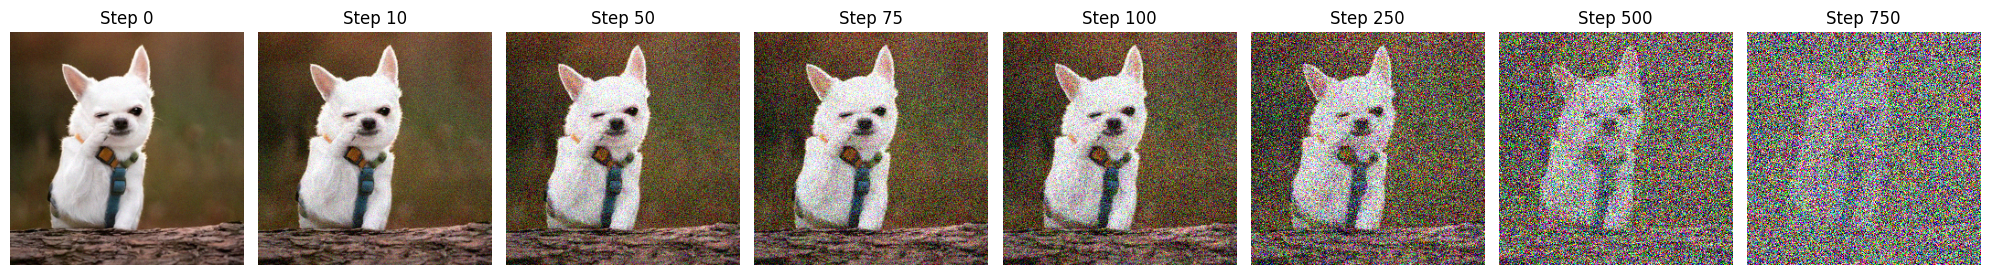

In [ ]:
from PIL import Image
import torch
import numpy as np
import math
import matplotlib.pyplot as plt


# Set up generator and sampler
generator = torch.Generator()
generator.manual_seed(0)
ddpm_sampler = DDPMSampler(generator)

# List of noise levels to visualize (time steps)
noise_levels = [0, 10, 50, 75, 100, 250, 500, 750]

# Load image
img = Image.open("/content/images.jpg").convert("RGB").resize((256, 256))

# Convert to tensor and scale to [-1, 1]
img_tensor = torch.tensor(np.array(img), dtype=torch.float32).permute(2, 0, 1) / 255.0
img_tensor = (img_tensor * 2.0) - 1.0  # Scale to [-1, 1]
img_tensor = img_tensor.unsqueeze(0)  # Add batch dim: (1, 3, H, W)

# Create a batch of repeated images for each timestep
batch = img_tensor.repeat(len(noise_levels), 1, 1, 1)

# Generate noise
ts = torch.tensor(noise_levels, dtype=torch.long)
epsilons = torch.randn_like(batch)

# Apply DDPM noise based on timestep
noise_imgs = []
for i in range(len(ts)):
    a_hat = ddpm_sampler.alphas_cumprod[ts[i]]
    noisy = math.sqrt(a_hat) * batch[i] + math.sqrt(1 - a_hat) * epsilons[i]
    noise_imgs.append(noisy)

# Post-process and convert for visualization
noise_imgs = torch.stack(noise_imgs)
noise_imgs = (noise_imgs.clamp(-1, 1) + 1) / 2  # Back to [0, 1]
noise_imgs = (noise_imgs * 255).byte().permute(0, 2, 3, 1).cpu().numpy()

# Plotting
fig, axes = plt.subplots(1, len(noise_levels), figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(noise_imgs[i])
    ax.axis("off")
    ax.set_title(f"Step {noise_levels[i]}")
plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch
from diffusers import DiffusionPipeline

DEVICE = "gpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("/content/vocab (1).json", merges_file="/content/merges.txt")
model_file = "data/v1-5-pruned-emaonly.ckpt"
models = preload_models_from_standard_weights(model_file, DEVICE)

Using device: cuda


100%|██████████| 90/90 [00:47<00:00,  1.91it/s]


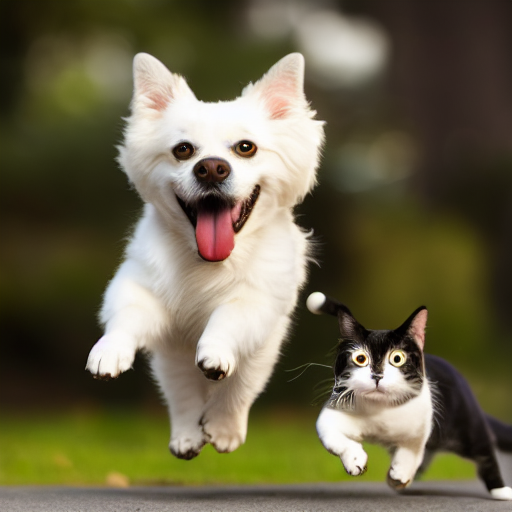

In [ ]:
## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "A dog run with a cat"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

input_image = input_image = Image.open("/content/images.jpg")
# Comment to disable image to image
image_path = "/content/images.jpg"
# input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.9

## SAMPLER

sampler = "ddpm"
num_inference_steps = 100
seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)